# Libraries and loading in the data

In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.distributed import Client
from dask import config as dask_config
import pandas as pd

In [2]:
plt.style.use('/Users/kyle/GoogleDrive/personal.mplstyle')

In [3]:
dask_config.set(temporary_directory='/tmp')
client = Client()
client

<Client: 'tcp://127.0.0.1:52231' processes=4 threads=16, memory=32.00 GiB>

In [4]:
client.cluster

In [5]:
xr.set_options(keep_attrs=True)
pd.options.display.float_format = '{:.2f}'.format

In [153]:
with xr.open_dataset(os.path.join('data', 'MERRA-2', 'Texas', 'merged-all-products-daily-averages-clipped.nc4')) as ds:
    ds.load()

ds['PM2.5'] = np.log(ds['PM2.5'] * 1e9)
ds['AODANA'] = np.log(ds['AODANA'])
ds

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/117)
    LWGAB        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    CLDTOT       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ALBNIRDF     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SWTDN        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    LWTUPCLRCLN  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    QV10M        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    HOURNORAIN   (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMAX       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMEAN      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2MMIN       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

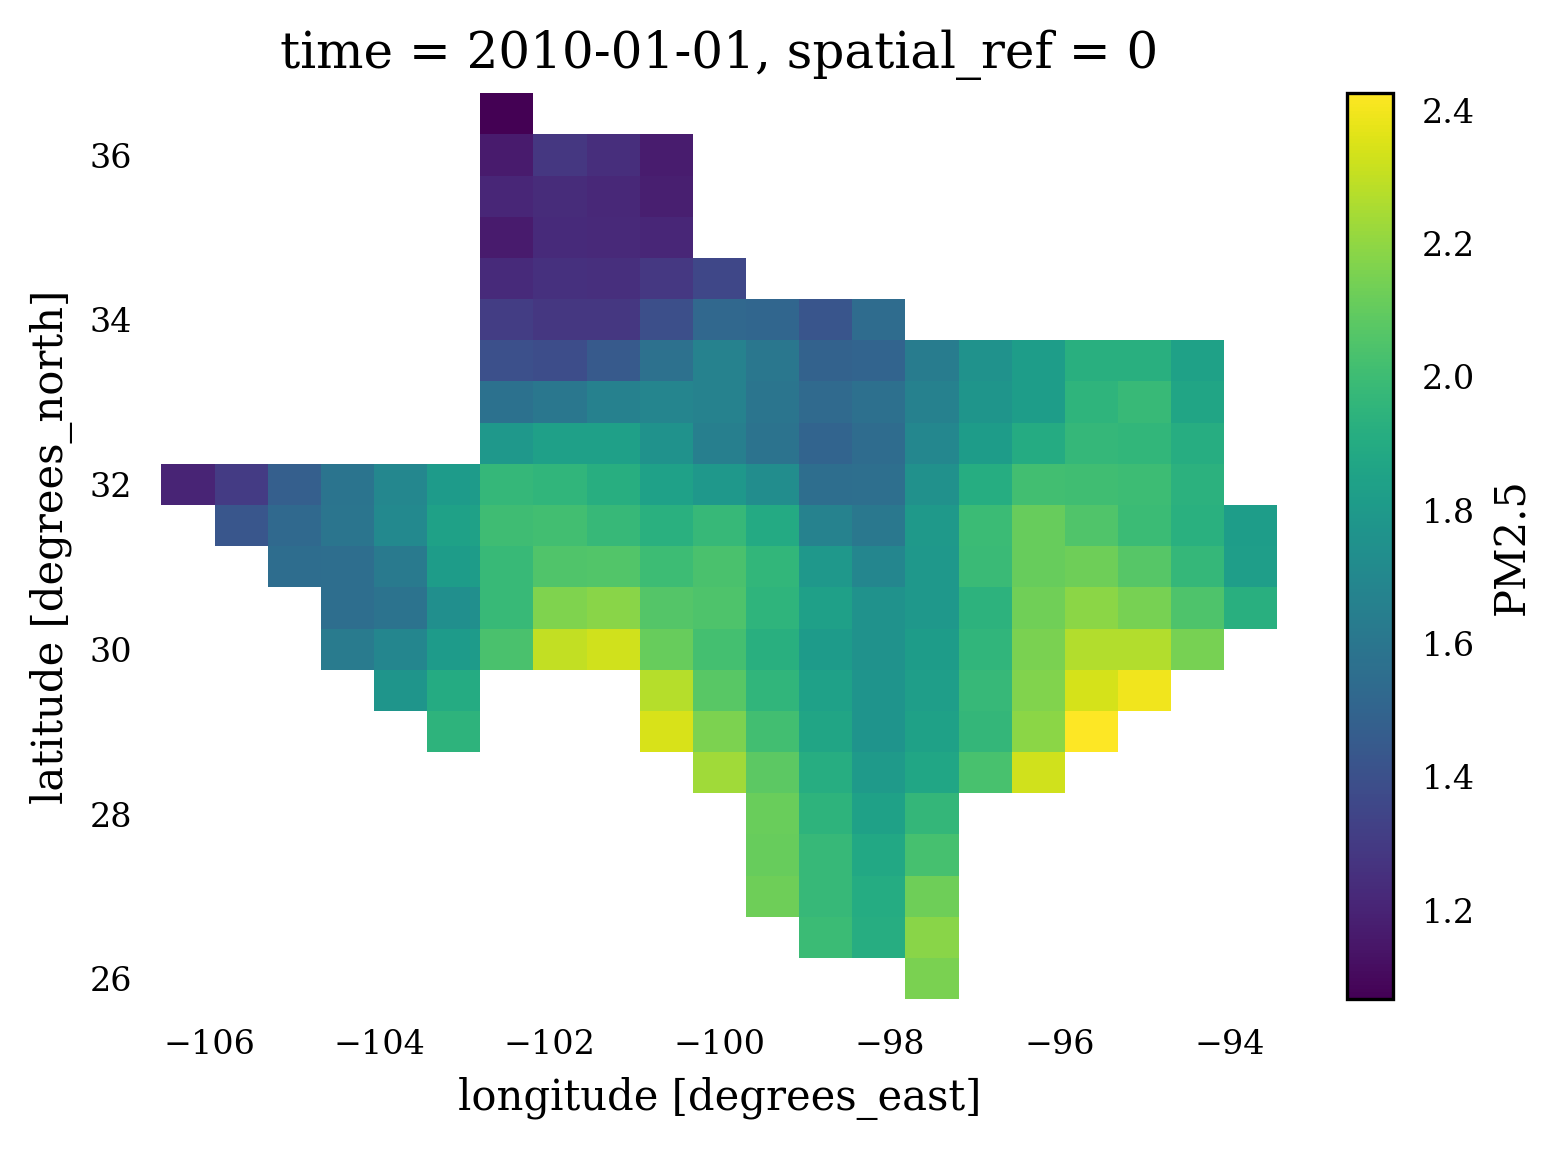

In [7]:
fig, ax = plt.subplots(dpi=300)

ds["PM2.5"][0].plot(ax=ax)

In [156]:
ds['MonthCos'] = np.cos(np.pi * 2 * ds.time.dt.month / 12)
ds['MonthSin'] = np.sin(np.pi * 2 * ds.time.dt.month / 12)

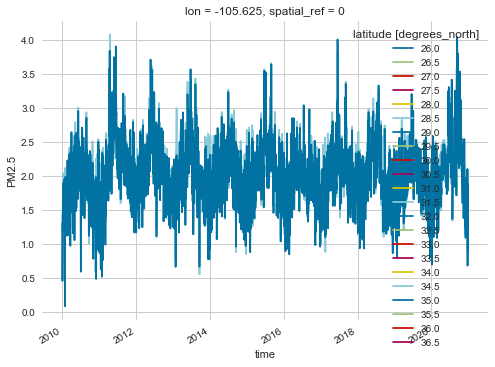

In [205]:
plt.rcParams.update({
    "text.usetex": False
})
ds['PM2.5'].isel(lon=1).plot.line(x='time');

# Feature Selection

120 features is far too many features. Further, some of the columns make up the PM2.5 column and many are not directly measurable by ground stations. The goal of this project is to work on data reminiscent of ground data and then compare the performance of several of the algorithms across the same time and spatial domain with the same features. A future study could then replicate the results but with data measured with satellites and weather stations.

Here, we will pick out a subset of the variables which are directly measurable and then choose the top `n` features with the highest mutual information value. There is no fundamental reason that we chose mutual information over Pearson's R.

First we will need to cut down the data to those columns that we need, split into the testing, training, and validation sets, and then run feature selection. The feature selection will be run only on the training set. The columns kept from the training set will be applied to the validation and testing sets.

A note on the train, test, validation split: The atmosphere has a memory. One can imagine that the concentration of PM2.5 on a Monday might affect the concentration on a Tuesday. Similar things can be said for other data variables. I do not know how, but it is possible that somehow some of the algorithms could learn a correlation between these variables, depending on which time componenet is used. To prevent the learned estimators from cheating when predicting the testing data, I wanted to ensure that there was space in time between the training and testing sets. That is why I did not use the normal `train_test_split` function provided by `scikit-learn`. Further, the validation set here is used only to check the out-of-sample performance **after** the algorithms are trained, meaning this validation set is not used in any of the algorithms. It is possible that some of the algorithms use a validation set, but that set would be a subset of the training set. Because the validation set made here is used to check the out-of-sample performance, it is possible that some of the actions taken could be influenced by those values, so the validation set should be considered to be a part of the training set. The final values reported at the end of this study will be reported on the testing set. The testing set will be run *exactly* once.

In [157]:
features_to_keep = [
    'PS',
    'QV2M',
    'QV10M',
    'T2M',
    'T10M',
    'U2M',
    'V2M',
    'U50M',
    'V50M',
    'U10M',
    'V10M',
    'TQL',
    'TQI',
    'TQV',
    'CLDTOT',
    'PM2.5',
    'AODANA',
    'ALBEDO',
    'TS',
    'MonthSin',
    'MonthCos',
    'TPRECMAX',
    'DISPH',
    'EMIS'
    ]

In [158]:
df = ds[features_to_keep]
df

<xarray.Dataset>
Dimensions:      (lat: 22, lon: 21, time: 4018)
Coordinates:
  * lat          (lat) float64 26.0 26.5 27.0 27.5 28.0 ... 35.0 35.5 36.0 36.5
  * lon          (lon) float64 -106.2 -105.6 -105.0 ... -95.0 -94.38 -93.75
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
    spatial_ref  int64 0
Data variables: (12/24)
    PS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV2M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    QV10M        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    T10M         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    U2M          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...           ...
    TS           (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    MonthSin     (time) float64 0.5 0.5 0.5 ... -2.449e-16 -2.449e-16 -2.449e-16
    MonthCos     (time) float64 0.866 0.866 0.866 0.866 ... 1.0 1.0 1.0 1.0
    TPRECMAX     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    DISPH        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    EMIS         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

In [159]:
train = df.sel(time=slice("2010", "2017")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
val = df.sel(time=slice("2018", "2019-06")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)
test = df.sel(time=slice("2019-07", "2020")).to_dataframe().reset_index().set_index('time').drop(['spatial_ref'], axis=1)

In [160]:
client.close()

Because the dataset was clipped to Texas, there are a lot of NaNs. We can just drop those since those are for location that are not in Texas.


In [161]:
train = train.dropna()
val = val.dropna()
test = test.dropna()
train.head()

lat    lon        PS  QV2M  QV10M    T2M   T10M   U2M   V2M  \
time                                                                       
2010-01-01 26.00 -97.50 102550.84  0.01   0.01 286.15 286.14  1.17 -4.50   
2010-01-02 26.00 -97.50 102471.00  0.01   0.01 285.52 286.11 -1.47 -0.55   
2010-01-03 26.00 -97.50 101837.12  0.01   0.01 289.48 289.97 -0.82  0.06   
2010-01-04 26.00 -97.50 102421.00  0.01   0.01 287.70 287.63 -0.90 -4.72   
2010-01-05 26.00 -97.50 102816.41  0.01   0.01 284.08 284.30 -1.30 -2.23   

            U50M  ...  CLDTOT  PM2.5  AODANA  ALBEDO     TS  MonthSin  \
time              ...                                                   
2010-01-01  1.90  ...    0.70   2.15   -2.30    0.17 286.53      0.50   
2010-01-02 -2.82  ...    0.77   1.83   -2.17    0.16 285.80      0.50   
2010-01-03 -2.22  ...    0.84   1.98   -1.76    0.16 289.42      0.50   
2010-01-04 -1.78  ...    0.87   2.66   -1.52    0.16 288.01      0.50   
2010-01-05 -2.58  ...    0.61   2.00   -2.10    0.17 284.90      0.50   

            MonthCos  TPRECMAX  DISPH  EMIS  
time                                         
2010-01-01      0.87      0.00   0.17  0.97  
2010-01-02      0.87      0.00   0.17  0.97  
2010-01-03      0.87      0.00   0.17  0.97  
2010-01-04      0.87      0.00   0.17  0.97  
2010-01-05      0.87      0.00   0.17  0.97  

[5 rows x 26 columns]

In [162]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest

def make_feature_selector(df, endogenous, k=15):
    """ Create a SelectKBest model for the dataset
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe holding the exogenous (independent) and endogenous (dependent) variables
    endogenous: str
        A string indicating which variable is the endogenous (dependent) variable
    k: int, default 15
        The number of desired features (columns of the dataframe, exogenous variables) to keep

    Returns
    ----------
    features: sklearn.feature_selection.SelectKBest
        A fitted SelectKBest model
    """
    X, y = df.drop(endogenous, axis=1), df[endogenous]
    features = SelectKBest(mutual_info_regression, k=k)
    features.fit(X, y)
    return features

def subset_features(df, features):
    """ Extract the desired features from a dataframe
    
    Parameters
    ----------
    df : a pandas dataframe
        The dataframe holding the exogenous (independent) variables and excluding the endogenous (dependent) variable
    features: sklearn.feature_selection._BaseFilter
        A fitted sklearn.feature_selection._BaseFilter like SelectKBest

    Returns
    ----------
    X: pandas.DataFrame
        A subset of `df` containing only those features selected by `features`
    """
    
    return df.loc[:, features.get_support()]

In [163]:
import pickle

load = False

if load:
    with open('models/feature_selection_lod_aod.pcl', 'rb') as f:
        features = pickle.load(f)
else:
    features = make_feature_selector(train, 'PM2.5', k=10)
    with open('models/feature_selection_lod_aod.pcl', 'wb') as f:
        pickle.dump(features, f)

In [16]:
x_train, y_train = subset_features(train.drop('PM2.5', axis=1), features), train['PM2.5']

In [17]:
x_val, y_val = subset_features(val.drop('PM2.5', axis=1), features), val['PM2.5']

In [18]:
x_test, y_test = subset_features(test.drop('PM2.5', axis=1), features), test['PM2.5']

# Utility

In [19]:
def summarize_scores(scores):
    r2 = scores["test_r2"].mean()
    mae = np.abs(scores["test_neg_mean_absolute_error"]).mean()
    rmse = np.abs(scores["test_neg_root_mean_squared_error"]).mean()
    return r2, mae, rmse
    
def print_scores(scores):
    r2, mae, rmse = summarize_scores(scores)
    
    print('R2, MAE, RMSE')
    print(f'{r2:.2f}, {mae:.2f}, {rmse:.2f}')
    
def size_in_bytes(df):
    return df.values.nbytes + df.index.nbytes + df.columns.nbytes

def size_in_kilobytes(df):
    return size_in_bytes(df) / 1024

def size_in_megabytes(df):
    return size_in_bytes(df) / 1024 ** 2

# Plotting

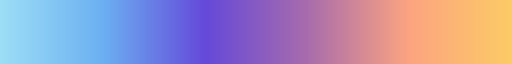

In [20]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#directly-creating-a-segmented-colormap-from-a-list
colors = ["#9CDEF6", "#6CB0F2", "#6549DA", "#A86CAD", "#FCA481", "#FDCB66"]
announce = LinearSegmentedColormap.from_list("Announce", colors)
announce

In [147]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import contextily as cx

from yellowbrick.regressor import ResidualsPlot

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

import scipy.stats as stats

def residuals_plot(model, x, y, unseen_x, unseen_y, unseen_label = 'Validation', train_color='#9CDEF6', test_color='#6549DA'):
    fig, ax = plt.subplots(dpi=300)
    x_test = unseen_x.copy()

    visualizer = ResidualsPlot(model, ax=ax, hist=False, qqplot=True, 
                              train_alpha=0.5, 
                              test_alpha=0.5,
                              train_color=train_color,
                              test_color=test_color,
                              is_fitted=True)

    visualizer.fit(x, y)  # Fit the training data to the visualizer
    visualizer.score(x_test, unseen_y)  # Evaluate the model on the test data

    for _ax in fig.get_axes():
        _ax.tick_params(axis='both', labelsize=10, width=0, which='both')
        _ax.grid(True, alpha=0.2)

    visualizer._labels = [i.replace('Test', unseen_label) for i in visualizer._labels]
    visualizer.show()    

def score_boxplot(score_type, *args, title='', labels=None, ax=None, tick_fontsize=10, title_fontsize=20, take_absolute_value=False):
    if labels is None:
        raise ValueError("Provide labels")
    scores = [arg[score_type] for arg in args]
    
    if take_absolute_value:
        scores = list(map(np.abs, scores))
    
    if ax is None:
        fig, ax = plt.subplots(dpi=300)
    
    boxes = ax.boxplot(scores, labels=labels, vert=False, showmeans=True)
    
    ax.set_title(title, fontsize=title_fontsize)
    
    ax.tick_params(axis='both', labelsize=tick_fontsize, width=0, which='both')
    ax.grid(True, alpha=0.5)
    
    return boxes

def grouped_boxplot_with_table(scores, labels, save=False, filename='scores.png', fs=10):
    fig = plt.figure(figsize=(10, 5.0), dpi=300)

    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, :])

    r2_boxes = score_boxplot('test_r2', *scores, 
                  title='$R^2$', labels=labels, ax=ax1, 
                  tick_fontsize=fs)

    mae_boxes = score_boxplot('test_neg_mean_absolute_error', *scores, 
                  title='MAE', labels=labels, ax=ax2, 
                  tick_fontsize=fs, take_absolute_value=True)

    rmse_boxes = score_boxplot('test_neg_root_mean_squared_error', *scores, 
                  title='RMSE', labels=labels, ax=ax3, 
                  tick_fontsize=fs, take_absolute_value=True)

    for boxes in [r2_boxes, mae_boxes, rmse_boxes]:
        for mean in boxes['means']:
            mean.set_markerfacecolor('#A86CAD')
        for median in boxes['medians']:
            median.set_color('#FCA481')

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()

    ax2.set_yticklabels([])
    ax3.set_yticklabels([])

    plt.rc('text', usetex=True)
    ax2.set_xlabel(r'$\frac{\mu g}{m^3}$', fontsize=16)
    ax3.set_xlabel(r'$\frac{\mu g}{m^3}$', fontsize=16)

    ax4.axis('off')
    ax4.axis('tight')

    cell_text = []
    for score in scores:
        vals = [f'{i:.2f}' for i in summarize_scores(score)]
        cell_text.append(vals)

    table = ax4.table(cellText=cell_text,
                          rowLabels=labels,
                          colLabels=['$R^2$', 'MAE', 'RMSE'],
                          loc='best', edges='open', cellLoc='center')

    fig.tight_layout()
    if save:
        plt.savefig(filename)
        
    return fig, (ax1, ax2, ax3, ax4)
        
def plot_prediction_error(model, x, y, 
                          legend_fontsize = 12, 
                          unity_color = '#A86CAD', 
                          fit_color = '#FCA481', 
                          r2_ax_locx = .1, 
                          r2_ax_locy = .8, 
                          dropped_spines = False, 
                          name = ''):
    """
    Plot true values of y against the predicted values, y_hat, made by the model
    
    
    Parameters
    ----------
    model : an sklearn-like fitted model
        A fitted model
    x : array_like
        The data used to predict y
    y : array_like
        The data being predicted
    legend_fontsize : int, optional default 12
        The fontsize in points
    unity_color : string, optional default '#A86CAD'
        The color used to paint the line y = x
    fit_color : string, optional default '#FCA481'
        The color used to paint the fit line made by a linear regression of y_hat ~ y
    r2_ax_locx : float, optional default .1
        The x position of the r squared label on the graph in axes coordinates
    r2_ax_locy : float, optional default .82
        The y position of the r squared label on the graph in axes coordinates
    dropped_spines : boolean, optional default False
        If set to true, the bottom and left spines will be drawn and offset 
        and the grid will be turned off
    name: str
        Text that will be prepended to the title of the plot
    """
    y_hat = model.predict(x)

    fit = LinearRegression().fit(y.values.reshape(-1, 1), y_hat)

    fit_r2 = fit.score(y.values.reshape(-1, 1), y_hat)
    equation = f'y = {fit.coef_[0]:.2f} x + {fit.intercept_:.2f}'

    line = np.arange(0, y_val.max(), 1)

    # historgrams on the side: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
    fig = plt.figure(dpi=300)
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.05

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]
    
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    binwidth = 0.25
    xymax = max(np.max(np.abs(y)), np.max(np.abs(y_hat)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(y, bins=bins, color='#9CDEF6')
    ax_histy.hist(y_hat, bins=bins, orientation='horizontal', color='#9CDEF6')
    
    ax_histy.set_title(name)
    
#     ax_histy.set_yscale('log')
#     ax_histx.set_xscale('log')
    
#     density = stats.kde.gaussian_kde(y)
#     y_true_range = np.arange(0, y.max(), .1)
#     y_true_density = density(y_true_range)

#     ax_histx.plot(y_true_range, y_true_density, alpha=0.7, lw=1, color='#9CDEF6')
#     ax_histx.fill_between(y_true_range, y_true_density, alpha=0.4, color='#9CDEF6')
    
    ax.plot(line, line, '--', color=unity_color, lw=1, label='unity')
    ax.plot(line, fit.predict(line.reshape(-1, 1)), color=fit_color, lw=1, label=equation)

    ax.scatter(y, y_hat, alpha=0.5, color='#9CDEF6', edgecolors='#6549DA')
    
    mae = mean_absolute_error(y, y_hat)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    fontdict = {'fontsize': legend_fontsize}
    ax.text(r2_ax_locx, r2_ax_locy, 
            fr'$R^2 ={fit_r2:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)
    ax.text(r2_ax_locx, r2_ax_locy - .05, 
            fr'$RMSE ={rmse:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)
    ax.text(r2_ax_locx, r2_ax_locy - .1, 
            fr'$MAE ={mae:.2f}$', 
            transform=ax.transAxes, 
            fontdict=fontdict)

#     fig.suptitle(f'{name}MAE = {mae:.2f}' + r' $\frac{\mu g}{m^3}$' + f'  RMSE = {rmse:.2f}' + r' $\frac{\mu g}{m^3}$')

    ax.set_xlabel(r'True $\log [PM_{2.5}]~ \frac{\mu g}{m^3}$')
    ax.set_ylabel(r'Predicted $\log [PM_{2.5}]~ \frac{\mu g}{m^3}$')

    ax.legend(fontsize=legend_fontsize)
    
    round_up = lambda num, divisor: np.ceil(num / divisor) * divisor
    
    if dropped_spines:
        ax.set_xlim((0, round_up(y_val.max(), 10)))
        ax.set_ylim((0, round_up(y_hat.max(), 10)))
        
        ax.grid(False)
        
        ax.spines['left'].set_visible(True)
        ax.spines['left'].set_position(('outward', 10))
        
        ax.spines['bottom'].set_visible(True)
        ax.spines['bottom'].set_position(('outward', 10))
        
        ax.tick_params(direction='out', length=4, width=1, color='.8')
        
def feature_importance(importances, model_name, columns, fontsize=10, fill_color='#9CDEF6aa', edge_color='#6549DA'):    
    indices = np.argsort(importances)[::]
    
    fig, ax = plt.subplots(figsize=(15, 15), dpi=300)
    
    ax.set_title(f"Feature importances for {model_name}", fontsize=int(fontsize*1.2))
    
    ax.barh(range(len(columns)), importances[indices],
            color=fill_color, edgecolor=edge_color, yerr=None, align="center")
    
    for patch in ax.patches:
        bl = patch.get_xy()
        x = 0
        y = 0.5*patch.get_height() + bl[1]
        ha = 'left' if patch.get_width() > 0 else 'right'
        ax.text(x, y, f"{patch.get_width():.2f}", ha=ha ,va='center', color='black')
    
    ax.set_yticks(range(len(columns)))
    ax.set_yticklabels(columns[indices], fontsize=fontsize)

def histogram_density_plot(df, nbins = 30, by = None, title = None, bin_fontsize = 8, tick_fontsize=6, xlabel=None, ylabel=None, dpi=600, xmin=0, ax = None, xlim = None):
    if ax is None:
        fig, ax = plt.subplots(dpi=dpi)

    density = stats.kde.gaussian_kde(df[by].values)
    x = np.arange(xmin, df[by].values.max(), .01)
    density = density(x)

    ax.plot(x, density, alpha=0.7, lw=1, color='#9CDEF6')
    ax.fill_between(x, density, alpha=0.4, color='#9CDEF6')

    n, bins, patches = ax.hist(df[by], bins=nbins, rwidth=0.75, density=True, alpha=0.7, zorder=3, color='#6549DA')
    ax.set_xticks(bins)
    counts = df[by].value_counts(bins=nbins, sort=False)
    for count, bar in zip(counts, patches):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+.0005, f'{count}', fontsize=bin_fontsize, ha='center')

    if xlim is None:
        ax.set_xlim((xmin, df[by].values.max()))
    else:
        ax.set_xlim(xlim)
        
    ax.tick_params(axis='both', labelsize=tick_fontsize, width=0, which='both')
    ax.grid(True, alpha=0.2)
    
    if title is not None:
        ax.set_title(title)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    return bins

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

def map_predicted(ds, nrows, ncols, width=504, colormap='viridis'):
    """
    Map the values in ds in a grid of plots

    Parameters
    ----------
    ds : xarray.DataSet
        A dataset with any number of lat/lon dimensions and only one time dimension
    nrows : int
        The number of rows of the plot
    ncols: int
        The number of columns of the plot
    width: float
        The width of the figure in points. This value is passed to set_size to determine the figure size
    colormap: string or matplotlib colormap
        The colormap to use
    """
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=set_size(width))

    source = {key: value for key, value in cx.providers.Wikimedia.items()}
    attribution = source['attribution']
    source['attribution'] = ''

    var_min = min(ds.min().to_pandas().tolist())
    var_max = max(ds.max().to_pandas().tolist())

    columns = [x.name for x in ds.data_vars.values()]
    last_idx = len(columns) - 1
    
    for idx, column, ax in zip(range(len(columns)), columns, np.ravel(axes)):
        ds[column] \
            .plot(ax=ax, alpha=1, add_colorbar=False, cmap=colormap, vmin=var_min, vmax=var_max)

        cx.add_basemap(ax=ax, crs='EPSG:4326', source=source)

        if idx % ncols != 0:
            ax.set_yticklabels([])
        if idx < (nrows - 1) * ncols:
            ax.set_xticklabels([])

        ax.set_ylabel('')
        ax.set_xlabel('')

        ax.set_title(column, fontdict={'fontsize': 8})
        ax.tick_params(axis='both', labelsize=8, pad=2)

    for ax in np.ravel(axes)[idx+1:]:
        ax.remove()
    axes = np.ravel(axes)[:idx+1]

    mappable = ScalarMappable(norm=Normalize(vmin=var_min, vmax=var_max), cmap=colormap)
    cbar = fig.colorbar(mappable, ax=axes.flat)
    cbar.outline.set_linewidth(0)
    
    return fig, axes

# Modeling

## Model Collection

In [221]:
# from dask_ml.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, BayesianRidge, LinearRegression
from sklearn.svm import LinearSVR
from sklearn import linear_model

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# on mac, dask xgboost relies on your hostname resolving to an address
# you may have to edit your /etc/hosts file: https://apple.stackexchange.com/questions/253817/cannot-ping-my-local-machine
# related information here: https://bugs.python.org/issue35164
# from dask_ml.xgboost import XGBRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline

from dask_ml.preprocessing import StandardScaler
from dask_ml.preprocessing import PolynomialFeatures
import dask.array as da

import time

import pickle
from joblib import dump, load
import joblib

from statsmodels.api import MixedLM
from sklearn.base import BaseEstimator, RegressorMixin

from pymer4 import Lmer

from tqdm.notebook import tqdm
import glob

from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

class MixedLMWrapper(BaseEstimator, RegressorMixin):
    """ 
    An sklearn-style wrapper for the statsmodels MixedLM regressor

    MixedLM documentation: https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLM.html?highlight=mixedlm#statsmodels.regression.mixed_linear_model.MixedLM
    Code taken and modified from here: https://stackoverflow.com/a/48949667/5217293
    
    Other useful resources:
      - https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html
      - https://www.statsmodels.org/stable/mixed_linear.html
      - https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLM.fit_regularized.html#statsmodels.regression.mixed_linear_model.MixedLM.fit_regularized
      - https://nbviewer.jupyter.org/urls/umich.box.com/shared/static/lc6uf6dmabmitjbup3yt.ipynb
      - https://nbviewer.jupyter.org/urls/umich.box.com/shared/static/6tfc1e0q6jincsv5pgfa.ipynb
    
    Attributes
    ----------
    formula : string
        The formula used by the MixedLM model. See the constructor for more details on this
    dependent_label : string
        The label of the dependent variable
    random_effect_variable : string
        The variable that will group the data to control for its random effect
    model_ : statsmodels.regression.mixed_linear_model.MixedLM
        The mixed effect model
        Set after calling fit()
    results_ : statsmodels.regression.mixed_linear_model.MixedLMResults
        The results of the mixed effect model fit.
        Set after calling fit()
    """
    def __init__(self, formula, dependent_label, groups, vc_formula = None, re_formula = None):
        """
        Initialize the MixedLM model

        Parameters
        ----------
        formula : pandas DataFrame
            A formula used to initialize the MixedLM using MixedLM.from_formula(): https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html#statsmodels.regression.mixed_linear_model.MixedLM.from_formula
            The formula is an R-style formula. Read more here: https://www.statsmodels.org/stable/examples/notebooks/generated/formulas.html
        dependent_label : string
            The label of the dependent variable
        groups : string
            The variable that will group the data to control for its random effect
        vc_formula : dictionary, default None
            The variance component (vc) formula that indicates what subgroups within the group should be fit
        re_formula : string
            One-sided random effect formula
        """
        self.formula = formula
        self.dependent_label = dependent_label
        self.groups = groups
        self.vc_formula = vc_formula
        self.re_formula = re_formula

    def fit(self, X, y):
        """
        Fit the MixedLM model

        Parameters
        ----------
        X : array_like
            The covariates used to predict `y`
        y : array_like
            The values that should be predicted
        """
        data = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
        data.columns = X.columns.tolist() + [self.dependent_label]

        self.model_ = MixedLM.from_formula(self.formula, 
                                           data=data, 
                                           groups=self.groups,
                                           vc_formula=self.vc_formula, 
                                           re_formula=self.re_formula)
        self.results_ = self.model_.fit(method="lbfgs")
        
        return self
        
    def predict(self, X):
        """
        Make a prediction with the fitted model

        Parameters
        ----------
        X : array_like
            The covariates used to make a prediction
        """
        return self.results_.predict(X)
    
    def summary(self):
        """
        Print a summary of the fitted results 
        
        See the MixedLMResults.summary documentation for more information: https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLMResults.summary.html#statsmodels.regression.mixed_linear_model.MixedLMResults.summary
        """
        return self.results_.summary()
    
    def compute_scores(self, X, y):
        """
        Predict the values and return three scores
        
        Parameters
        ----------
        X : array_like
            The covariates used to predict `y`
        y : array_like
            The values that should be predicted
            
        Returns
        ----------
            scores: tuple
                r2_score, root mean squared error, mean absolute error
        """
        y_pred = self.results_.predict(X)
        
        r2 = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred, squared=False)
        mae = mean_absolute_error(y, y_pred)
        scores = r2, rmse, mae
        return scores

class Pymer4Wrapper(BaseEstimator, RegressorMixin):
    """ 
    An sklearn-style wrapper for the Pymer4 Lmer model, which calls the lmer model from R
    
    https://eshinjolly.com/pymer4/api.html
    
    Attributes
    ----------
    """
    def __init__(self, formula):
        """
        Parameters
        ----------
        """
        self.formula = formula

    def fit(self, X, y):
        """
        Fit the Pymer4 model

        Parameters
        ----------
        X : array_like
            The covariates used to predict `y`
        y : array_like
            The values that should be predicted
        """
        data = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
        data.columns = X.columns.tolist() + [y.name]

        self.model_ = Lmer(self.formula, data=data)
        
        self.model_.fit()
        
        return self
        
    def predict(self, X):
        """
        Make a prediction with the fitted model

        Parameters
        ----------
        X : array_like
            The covariates used to make a prediction
        """
        return self.model_.predict(X)
    
    def summary(self):
        """
        Print a summary of the fitted results 
        
        See the MixedLMResults.summary documentation for more information: https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLMResults.summary.html#statsmodels.regression.mixed_linear_model.MixedLMResults.summary
        """
        return self.model_.summary()
    
    def compute_scores(self, X, y):
        """
        Predict the values and return three scores
        
        Parameters
        ----------
        X : array_like
            The covariates used to predict `y`
        y : array_like
            The values that should be predicted
            
        Returns
        ----------
            scores: tuple
                r2_score, root mean squared error, mean absolute error
        """
        y_pred = self.model_.predict(X)
        
        r2 = r2_score(y, y_pred)
        rmse = mean_squared_error(y, y_pred, squared=False)
        mae = mean_absolute_error(y, y_pred)
        scores = r2, rmse, mae
        return scores    
    
class ModelCollection:
    """
    A class which helps to train and score a subset of sklearn algorithms.
    
    This class is not meant to do all of the work in terms of hyperparameter tuning,
    merely it serves to provide convenience for fitting and collecting cross-validated scores
    of several model in a few lines of code. Optimizing parameters should be done by hand and the
    model in question should be replaced in the dictionary. Note that any model can be added to the
    models attribute so long as the model provides the regular sklearn api functions of fit() and score()
    
    Below is a listing of class attributes which can be modified directly but are not 
    changeable via the constructor. See the constructor docstring for more variables
    that can be set.
    
    Attributes
    ----------
    scoring : array of strings
        passed to sklearn.model_selection.cross_validate's scoring parameter
    models : dictionary of strings and models
        models presenting an sklearn-like API
    scores_ : dictionary
        keys are strings of the model names with values being a dictionary
        indicating the r2 score, mean absoulte error, and root mean squared error
        this attribute is set after calling compute_scores()
    cross_val_scores_ : dictionary
        keys are strings of the model names with values being the 
        output of sklearn.model_selection.cross_validate
        this attribute is set after calling compute_cross_validation_scores()
    """
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
    
    def __init__(self, x, y, cv=10, stratify=False, lme_dependent = '', lme_independents = '', lme_group = 'DoY', lme_formula='', lme_locations=None):
        """
        Initialize the necessary data for this class
        
        x will be copied twice, once for all models except linear mixed effect, and again for mixed effect.
        Mixed effect needs a grouping parameter. This parameter, lme_group can either be 'DoY' (day of the year)
        'Month', or 'Season'. The copied x with have this added as a column
        
        y will be copied once. In this copy, the name of the series will be replaced with `lme_dependent`

        Parameters
        ----------
        x : pandas.DataFrame
            the covariates used to predict x
        y : pandas.Series
            the dependant variable being predicted
        cv : int, optional default 10
            the number of folds to use for cross validation. If stratify is True, this will also determine
            the number of bins to use to stratify y
        stratify : boolean, optional default False
            if True, y will be stratified with pandas.cut using the cv as the number of bins so that
            stratified cross validation will be done. 
            Read more here: https://stackoverflow.com/a/54946733/5217293
        lme_dependent: string, default ''
            The dependent variable that linear mixed effect will predict. This string will replace the name of the
            `y` series for use by the linear mixed effect model
        lme_independents: string, default ''
            The independents variables used to predict `lme_dependent`. This will be used to construct an R-style formula
        lme_group: string, default 'DoY'
            One of 'DoY' (day of the year), 'Month', 'Season', or 'Location'. Whatever value is chosen, a column will be added
            to a copied version of x and that column will be used to do the grouping. If 'Location' is specified, an array 
            of locations must be passed to lme_location
        lme_locations: pd.Series default None
            A pandas Series with the same index as x whose column values should indicate a locaitonal grouping of each row in x
        """
        
        self.x = x.copy()
        self.y = y
        
        self.scaler = None
        self.scaled_x = None
        
        self.lme_dependent = lme_dependent
        self.lme_independents = lme_independents
        self.lme_group = lme_group
        self.lme_formula = lme_formula
        self.lme_locations = lme_locations
        
        self.scores_ = {}
        self.cross_val_scores_ = {}
        
        self.cv = cv
        self.stratified_kfold = stratify
        
        self._setup_models()
    
    def fit(self):
        """
        Fit each model with the data passed into the constructor
        
        Returns
        ----------
        fit_times: dictionary
            keys are strings of the model names, values are floats representing the time taken
            to fit the model in seconds
        """
        fit_times = {}
        
        pbar = tqdm(self.models.keys())
        for name in pbar:
            pbar.set_description(f'Fitting {name}')
            dt = self.fit_model(name)
            fit_times[name] = dt
        
        return fit_times
    
    def fit_model(self, model_name):
        """
        Fit the model
        
        Parameters
        ----------
        model_name: str
            The name of the model to be fit. This name must be a key in self.models
            
        Returns
        ----------
        fit_times: dictionary
            keys are strings of the model names, values are floats representing the time taken
            to fit the model in seconds
        """
        
        _x, _y = self._get_xy(model_name)
        
        start = time.time()
            
        model = self.models[model_name]
        self.models[model_name] = model.fit(_x, _y)

        # in seconds
        return time.time() - start
    
    def compute_cross_validation_scores(self):
        """
        Compute the cross validated scores using sklearn.model_selection.cross_validate for
        each model.
        
        This method sets the cross_val_scores_ attribute on this object.
        
        Returns
        ----------
        cross_val_scores_ : dictionary
            keys are strings of the model names with values being the output 
            of sklearn.model_selection.cross_validate
        """
        self.cross_val_scores_ = {}
        pbar = tqdm(self.models.items())
        for name, _ in pbar:
            pbar.set_description(f'Cross-validating {name}')
            self._compute_scross_validation_for_model(name)
            
        return self.cross_val_scores_

    def compute_cross_validation_scores_for_model(self, model_name):
        """
        Compute the cross validated scores using sklearn.model_selection.cross_validate for
        each model.
        
        If this object has previously had a cross-validation score made for `model_name`,
        then the cross_val_scores_ dictionary is updated
        
        Parameters
        ----------
        model_name: str
            The name of the model to be fit. This name must be a key in self.models
            
        Returns
        ----------
        cross_val_scores_ : dictionary
            keys are strings of the model names with values being the output 
            of sklearn.model_selection.cross_validate
        """
        if not 'cross_val_scores_' in mc.__dict__:
            self.cross_val_scores_ = {}
        else:
            if model_name in self.cross_val_scores_:
                del self.cross_val_scores_[model_name]

        self._compute_scross_validation_for_model(model_name)
        
        return self.cross_val_scores_
    
    def _compute_scross_validation_for_model(self, model_name):
        model = self.models[model_name]
        if getattr(model, 'n_jobs', None) is not None:
            model.n_jobs = -1
        _x, _y = self._get_xy(model_name)
        self.cross_val_scores_[model_name] = cross_validate(model, 
                                  _x, _y, 
                                  cv = self._get_cross_validation(), 
                                  scoring = self.scoring)
          
    def compute_scores(self, x, y):
        """
        Compute the r2, mae, and rmse scores for each model using x and y.
        
        This method sets the cross_val_scores_ attribute on this object.
        
        Parameters
        ----------
        x : pandas DataFrame
            the covariates used to predict x
        y : array_like
            the dependant variable being predicted
            
        Returns
        ----------
        scores_ : dictionary
            keys are strings of the model names with values being a dictionary
            indicating the r2 score, mean absoulte error, and root mean squared error
            this attribute is set after calling compute_scores()
        """
        self.scores_ = {}
        for name in self.models.keys():
            r2, rmse, mae = self.compute_scores_for_model(name, x, y)

            self.scores_[name] = {
                'r2' : r2,
                'rmse' : rmse,
                'mae' : mae
            }
            
        return self.scores_
    
    def compute_scores_for_model(self, model_name, x, y):
        """
        Compute the r2, mae, and rmse scores for each model using x and y.
        
        This method sets the cross_val_scores_ attribute on this object.
        
        Parameters
        ----------
        model_name : string
            Which model to score
        x : pandas DataFrame
            the covariates used to predict x
        y : array_like
            the dependant variable being predicted
            
        Returns
        ----------
        scores : tuple
            the r2 score, root mean squared error, and mean absoulte error
        """
        model = self.models[model_name]
        
        _x = self._transform_x_for_prediction(model_name, x)

        y_pred = model.predict(_x)
        scores = (
            r2_score(y, y_pred),
            mean_squared_error(y, y_pred, squared=False),
            mean_absolute_error(y, y_pred)
        )
            
        return scores
    
    def predict(self, x):
        predicitons = {}
        
        for model_name in self.models.keys():
            predicitons[model_name] = self.predict_model(model_name, x)
    
    def predict_model(self, model_name, x):
        
        model = self.models[model_name]
        x = self._transform_x_for_prediction(model_name, x)
        return model.predict(x)
        
    def save(self, filepath):
        """
        Save all of the models to the disk using joblib as recommended 
        by sklearn.
        
        Read more here: https://sklearn.org/modules/model_persistence.html
        
        Parameters
        ----------
        filename : string, optional default ''
            The full path and filename to save the model to. This savs with joblib,
            so it would be smart to include the extension of .joblib.
        """
        
        ar = [(name, model) for name, model in self.models.items()]
        ar.append(('scaler', self.scaler))
        dump(ar, filepath)
        
    def load(self, filename):
        """
        Load all of the models from the disk using joblib as recommended 
        by sklearn.
        
        Read more here: https://sklearn.org/modules/model_persistence.html
        
        Parameters
        ----------
        filename : string, optional default ''
            The full path and filename to load the model from.
        """
        ar = load(filename)
        names_models, self.scaler = ar[:-1], ar[-1][0]
        self.models = {name: model for name, model in names_models}
            
    def save_model_cross_val_scores(self, filename=''):
        """
        Save all of the model scores to the disk.
        
        Parameters
        ----------
        filename : string, optional default ''
            The full path and filename to save the scores to.
        """

        with open(filename, 'wb') as f: 
            pickle.dump(self.cross_val_scores_, f)

    def load_model_cross_val_scores(self, directory='', prefix=''):
        """
        Load all of the model scores from the disk.
        
        Parameters
        ----------
        filename : string, optional default ''
            The full path and filename to load the scores from.
        """
        
        with open(filename, 'rb') as f: 
            self.cross_val_scores_ = pickle.load(f)
    
    def _get_cross_validation(self):
        """
        Return a cross validation depending on the value of self.stratified_kfold
        
        Returns
        ----------
        cv : int or an sklearn StratifiedKFold
        """
        if self.stratified_kfold:
            return self._stratified_kfold()
        return self.cv
    
    def _setup_models(self):
        """
        Initialize the dictionary of models
        
        
        The individual models can be modified after this class is constructed by replacing
        values in self.models
        """
        #  models that will be placed into a pipeline
        elastic = ElasticNetCV(cv=10, 
                       l1_ratio=np.arange(0.1, 1.1, .1),
                       max_iter=10000
                      )
        mlp = MLPRegressor(max_iter=2000, early_stopping=True)
        mlp1 = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=100000, early_stopping=True)
        mlp2 = MLPRegressor(hidden_layer_sizes=(100, 50, 50, 50, 50), max_iter=100000, early_stopping=True)
        mlp3 = MLPRegressor(hidden_layer_sizes=(100, 50, 50, 50, 50, 100), max_iter=100000, early_stopping=True)

        formula = f'{self.lme_dependent} ~ {self.lme_independents}'
        
        self.models = {
            'Linear Regression': LinearRegression(),
            'Elastic Net' : Pipeline([('scaler', StandardScaler()), ('elastic', elastic)]),
            'Polynomial' : Pipeline([('poly', PolynomialFeatures()), ('linear', linear_model.LinearRegression())]),
            'Bayesian Ridge' : BayesianRidge(),
            'SVR' : Pipeline([('scaler', StandardScaler()), ('svr', LinearSVR())]),
            'Linear Mixed Effect': Pymer4Wrapper(formula=self.lme_formula),
            'MLP' : Pipeline([('scaler', StandardScaler()), ('mlp', mlp)]),
            'MLP1' : Pipeline([('scaler', StandardScaler()), ('mlp', mlp1)]),
            'MLP2' : Pipeline([('scaler', StandardScaler()), ('mlp', mlp2)]),
            'MLP3' : Pipeline([('scaler', StandardScaler()), ('mlp', mlp3)]),
            'Ada Boost' : AdaBoostRegressor(),
            'Random Forest' : RandomForestRegressor(n_jobs=-1),
            'Extra Trees' : ExtraTreesRegressor(n_jobs=-1),
            'Gradient Boost' : GradientBoostingRegressor(),
            'XGBoost' : XGBRegressor(n_jobs=-1, subsample=0.9, colsample_bytree=0.5)
        }

    def _stratified_kfold(self):
        # stratified k-fold cross validation: https://stackoverflow.com/a/54946733/5217293
        y_cat = pd.cut(self.y, self.cv, labels=range(self.cv))
        return StratifiedKFold(self.cv).split(self.x, y_cat)
    
    def _get_xy(self, model_name):
        if self.scaler is None:
            self.scaler = StandardScaler().fit(self.x)
            
        if self.scaled_x is None:
            scaled_values = self.scaler.transform(self.x)
            self.scaled_x = pd.DataFrame(scaled_values, index=self.x.index, columns=self.x.columns)
        
        if model_name == 'Linear Mixed Effect':
            _x = self._transform_x_for_lme(self.scaled_x)
            _y = self.y.copy().rename(self.lme_dependent)
        else:
            _x = self.scaled_x
            _y = self.y
        
        return _x, _y
    
    def _transform_x_for_prediction(self, model_name, x):
        scaled_values = self.scaler.transform(x)
        scaled_x = pd.DataFrame(scaled_values, index=x.index, columns=x.columns)
        
        if model_name == 'Linear Mixed Effect':
            _x = self._transform_x_for_lme(scaled_x)
        else:
            _x = scaled_x
        
        return _x
    
    def _transform_x_for_lme(self, x):
        if not x.empty:
            x_lme = x.copy()
            x_lme = pd.concat([x_lme, self.lme_locations], axis=1)
            if self.lme_group == 'DoY':
                x_lme['DoY'] = x_lme.index.dayofyear
            elif self.lme_group == 'Month':
                x_lme['Month'] = x_lme.index.month
            elif self.lme_group == 'Season':
                x_lme['Season'] = (x_lme.index.month%12 // 3 + 1)
            elif self.lme_group == 'Location':
                pass
        else:
            x_lme = []
        
        return x_lme   
    
class ModelStack():
    """
    A class which will stack the "best" models in a ModelCollection.
    
    To better estimate the dependent variable, the fitted models can be stacked.
    The function that will do the stacking can be any function that follows the sklearn API.
    By default, the stacking function is a multiple linear regressor and method 1 below is used.

    Stacking can be done in 2 ways:
        1. The predicted values from the selected models will be run through the stacking model
            and regressed against the predicted values.
        2. The residuals of the best models will be fitted to the stacking model.
    
    
    Attributes
    ----------
    mc : ModelCollection
        The fitted ModelCollection passed to the constructor
    stacker : object
        An estimator with an sklearn-like API
    estimation : string, one of ["predicted", "residuals"]
        "predicted" means that the stacker will be fitted with the predictions of each model, regressing
        against the actual value
        "residuals" means that the stacker will be regressed against the residuals
    """
    
    def __init__(self, mc, x, y, n = 3, criterion='rmse'):
        """
        Initialize the necessary data for this class

        Parameters
        ----------
        mc : ModelCollection
            A scored and fitted ModelCollection
        x : pandas DataFrame
            the covariates used to predict x
        y : array_like
            the dependant variable being predicted
        n : integer, default 3
            How many regressors to choose to form a stack
        criterion : string, optional default 'rmse'
            One of ['rmse', 'r2', 'mae']. This is the criterion used to rank
            the error of the models in the model collection and the top n will be used
            to fit an sklearn.ensemble.VotingRegressor
        """
        self.mc = mc
        self.x = x.copy()
        self.y = y
        
        self.n = n
        self.criterion = criterion
        
        self.voting_regressor_ = None
        
    def fit(self):
        """ Choose the model with the top self.n scores according to self.how and fit a voting
            regressor with them.
        """
        
        if mc.scores_:
            scores = self.mc.scores_
        else:
            _x = self.x.copy()
            scores = self.mc.compute_scores(_x, self.y)
        
        # split the model names and scores into two lists
        names, scores = map(np.array, zip(*[(name, vals[self.criterion]) for name, vals in scores.items()]))
        # sort them
        sort = np.argsort(scores)
        
        # r2 is a number between -inf and 1, but usually between 0 and 1, so reverse
        # the sort so that the best scores are first
        # for mae and rmse, smaller numbers are better models so the sort is already in the correct order
        if self.criterion == 'r2':
            sort = sort[::-1]
        
        # now, sort the models and scores by the criterion and pick off the number we need
        # to create the voting regressor
        names, scores = names[sort][:self.n], scores[sort][:self.n]
        
        models = [(name, self.mc.models[name]) for name in names]
        
        self.voting_regressor_ = VotingRegressor(models, n_jobs=-1)
        
        _x = self.x.copy()
        self.voting_regressor_.fit(_x, self.y)
        
    def compute_scores(self, x, y):
        """
        Compute the r2, mae, and rmse scores for each model using x and y.
        
        This method sets the cross_val_scores_ attribute on this object.
        
        Parameters
        ----------
        x : pandas DataFrame
            the covariates used to predict x
        y : array_like
            the dependant variable being predicted
            
        Returns
        ----------
        scores_ : dictionary
            keys are strings of the model names with values being a dictionary
            indicating the r2 score, mean absoulte error, and root mean squared error
            this attribute is set after calling compute_scores()
        """
        
        _x = x.copy()
        
        y_pred = self.voting_regressor_.predict(_x)
        
        self.scores_ = {
            'r2' : r2_score(y, y_pred),
            'rmse' : mean_squared_error(y, y_pred, squared=False),
            'mae' : mean_absolute_error(y, y_pred)
        }
            
        return self.scores_
    
    def predict(self, x):
        """Predict the input data
        Parameters
        ----------
        x : pandas DataFrame
            the covariates used to predict x
        Returns
        ----------
        prediction : array_like
            The results of the prediction made by the voting regressor
        """
        
        _x = x.copy()
        prediction = self.voting_regressor_.predict(_x)
        return prediction
    
    def save(self, directory='', prefix=''):
        """
        Save this model to the disk using joblib as recommended 
        by sklearn.
        
        Read more here: https://sklearn.org/modules/model_persistence.html
        
        Parameters
        ----------
        directory : string, optional default ''
            The directory that all of the models will be saved to.
            This can be a file system path
        prefix : string, optional default ''
            The prefix to prepend to each model name
        """
        
        dump(self.voting_regressor_, f'{directory}/{prefix}stacked.joblib')
        
    def load(self, directory='', prefix=''):
        """
        Load a stacking model from the disk using joblib as recommended 
        by sklearn.
        
        Read more here: https://sklearn.org/modules/model_persistence.html
        
        Parameters
        ----------
        directory : string, optional default ''
            The directory that all of the models were saved to.
            This can be a file system path
        prefix : string, optional default ''
            The prefix to prepended to each model name
        """
        
        self.voting_regressor_ = load(f'{directory}/{prefix}stacked.joblib')

## Training

### MGWR

In [99]:
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

In [112]:
x_train.loc['2010']

QV2M  QV10M    T2M   T10M   TQV  AODANA  ALBEDO     TS  MonthCos  \
time                                                                           
2010-01-01  0.01   0.01 286.15 286.14 12.73    0.10    0.17 286.53      0.87   
2010-01-02  0.01   0.01 285.52 286.11 13.60    0.11    0.16 285.80      0.87   
2010-01-03  0.01   0.01 289.48 289.97 25.18    0.17    0.16 289.42      0.87   
2010-01-04  0.01   0.01 287.70 287.63 20.30    0.22    0.16 288.01      0.87   
2010-01-05  0.01   0.01 284.08 284.30 13.92    0.12    0.17 284.90      0.87   
...          ...    ...    ...    ...   ...     ...     ...    ...       ...   
2010-12-27  0.00   0.00 277.39 277.64  6.39    0.04    0.22 277.01      1.00   
2010-12-28  0.00   0.00 277.09 277.81  8.41    0.07    0.20 276.02      1.00   
2010-12-29  0.00   0.00 276.55 277.03  6.73    0.05    0.21 275.95      1.00   
2010-12-30  0.00   0.00 280.24 280.32  9.15    0.03    0.22 280.10      1.00   
2010-12-31  0.00   0.00 272.65 272.56  4.32    0.05    0.22 272.82      1.00   

            DISPH  
time               
2010-01-01   0.17  
2010-01-02   0.17  
2010-01-03   0.17  
2010-01-04   0.17  
2010-01-05   0.17  
...           ...  
2010-12-27   0.14  
2010-12-28   0.14  
2010-12-29   0.14  
2010-12-30   0.14  
2010-12-31   0.14  

[75555 rows x 10 columns]

In [113]:
gwr_x, gwr_y = train.loc['2010'][x_train.columns.values.tolist() + ['lat', 'lon']], y_train.loc['2010']
coords = list(zip(gwr_x.lat, gwr_x.lon))
gwr_x = gwr_x.drop(['lat', 'lon'], axis=1)
gwr_x, gwr_y = gwr_x.values, gwr_y.values.reshape(-1, 1)

In [128]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

is_invertible(gwr_x[0:10])

True

In [132]:
train.loc['2010'].iloc[0:11].drop(['lat', 'lon'], axis=1)

PS  QV2M  QV10M    T2M   T10M   U2M   V2M  U50M   V50M  \
time                                                                       
2010-01-01 102550.84  0.01   0.01 286.15 286.14  1.17 -4.50  1.90  -8.03   
2010-01-02 102471.00  0.01   0.01 285.52 286.11 -1.47 -0.55 -2.82  -1.61   
2010-01-03 101837.12  0.01   0.01 289.48 289.97 -0.82  0.06 -2.22   0.56   
2010-01-04 102421.00  0.01   0.01 287.70 287.63 -0.90 -4.72 -1.78  -8.34   
2010-01-05 102816.41  0.01   0.01 284.08 284.30 -1.30 -2.23 -2.58  -5.33   
2010-01-06 102138.37  0.01   0.01 288.41 288.77 -1.68  2.28 -4.39   4.57   
2010-01-07 101709.35  0.01   0.01 289.55 289.76  0.64 -0.01  1.04   2.14   
2010-01-08 102981.90  0.00   0.00 277.98 277.72  1.33 -6.46  1.92 -10.71   
2010-01-09 103263.24  0.00   0.00 276.57 276.34  1.00 -3.93  1.69  -6.94   
2010-01-10 103278.32  0.00   0.00 279.90 280.86 -0.84 -1.51 -1.66  -3.76   
2010-01-11 102942.62  0.01   0.01 285.26 286.38 -2.14  0.92 -4.83   1.53   

            U10M  ...  CLDTOT  PM2.5  AODANA  ALBEDO     TS  MonthSin  \
time              ...                                                   
2010-01-01  1.60  ...    0.70   2.15    0.10    0.17 286.53      0.50   
2010-01-02 -2.08  ...    0.77   1.83    0.11    0.16 285.80      0.50   
2010-01-03 -1.33  ...    0.84   1.98    0.17    0.16 289.42      0.50   
2010-01-04 -1.24  ...    0.87   2.66    0.22    0.16 288.01      0.50   
2010-01-05 -1.78  ...    0.61   2.00    0.12    0.17 284.90      0.50   
2010-01-06 -2.59  ...    0.92   1.73    0.14    0.15 288.42      0.50   
2010-01-07  0.87  ...    0.82   2.56    0.21    0.15 289.37      0.50   
2010-01-08  1.80  ...    0.92   2.06    0.20    0.15 279.21      0.50   
2010-01-09  1.38  ...    0.29   1.41    0.08    0.18 278.28      0.50   
2010-01-10 -1.18  ...    0.20   1.55    0.07    0.17 280.69      0.50   
2010-01-11 -3.37  ...    0.43   1.50    0.09    0.17 284.56      0.50   

            MonthCos  TPRECMAX  DISPH  EMIS  
time                                         
2010-01-01      0.87      0.00   0.17  0.97  
2010-01-02      0.87      0.00   0.17  0.97  
2010-01-03      0.87      0.00   0.17  0.97  
2010-01-04      0.87      0.00   0.17  0.97  
2010-01-05      0.87      0.00   0.17  0.97  
2010-01-06      0.87      0.00   0.17  0.97  
2010-01-07      0.87      0.00   0.17  0.97  
2010-01-08      0.87      0.00   0.16  0.97  
2010-01-09      0.87      0.00   0.16  0.97  
2010-01-10      0.87      0.00   0.16  0.97  
2010-01-11      0.87      0.00   0.16  0.97  

[11 rows x 24 columns]

In [139]:
bw = Sel_BW(coords[:1000], gwr_y[:1000], gwr_x[:1000], fixed=True, spherical=True).search(criterion='AICc')
print(bw)

40.62


In [141]:
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.html#mgwr.gwr.GWR

model = GWR(coords, gwr_y, gwr_x, bw=bw, fixed=True, kernel='gaussian')
results = model.fit()

In [143]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                               75555
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           8696.616
Log-likelihood:                                                  -25535.706
AIC:                                                              51093.413
AICc:                                                             51095.417
BIC:                                                            -839860.139
R2:                                                                   0.547
Adj. R2:                                                              0.547

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Training

In [136]:
# x_train['LogAODANA'] = x_train['AODANA'].map(np.log)

In [223]:
x_train['AODANA'] = x_train['AODANA'].map(np.log)
x_train

QV2M  QV10M    T2M   T10M   TQV  AODANA  ALBEDO     TS  MonthCos  \
time                                                                           
2010-01-01  0.01   0.01 286.15 286.14 12.73   -2.30    0.17 286.53      0.87   
2010-01-02  0.01   0.01 285.52 286.11 13.60   -2.17    0.16 285.80      0.87   
2010-01-03  0.01   0.01 289.48 289.97 25.18   -1.76    0.16 289.42      0.87   
2010-01-04  0.01   0.01 287.70 287.63 20.30   -1.52    0.16 288.01      0.87   
2010-01-05  0.01   0.01 284.08 284.30 13.92   -2.10    0.17 284.90      0.87   
...          ...    ...    ...    ...   ...     ...     ...    ...       ...   
2017-12-27  0.00   0.00 268.51 268.18  5.52   -2.55    0.23 269.73      1.00   
2017-12-28  0.00   0.00 274.84 275.56  5.17   -3.33    0.22 274.02      1.00   
2017-12-29  0.00   0.00 276.87 278.15  5.61   -3.48    0.23 275.45      1.00   
2017-12-30  0.00   0.00 270.50 270.88  4.98   -3.06    0.21 270.99      1.00   
2017-12-31  0.00   0.00 266.24 265.78  4.84   -2.63    0.20 268.24      1.00   

            DISPH  LogAODANA  
time                          
2010-01-01   0.17      -2.30  
2010-01-02   0.17      -2.17  
2010-01-03   0.17      -1.76  
2010-01-04   0.17      -1.52  
2010-01-05   0.17      -2.10  
...           ...        ...  
2017-12-27   0.14      -2.55  
2017-12-28   0.14      -3.33  
2017-12-29   0.14      -3.48  
2017-12-30   0.14      -3.06  
2017-12-31   0.14      -2.63  

[604854 rows x 11 columns]

In [224]:
lme_group = 'location'
formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

locations = train['lat'].astype(str) + train['lon'].astype(str)
locations.name = 'Location'

mc = ModelCollection(
    x_train, y_train, 
    lme_dependent='PM', 
    lme_formula=formula, 
    lme_group=lme_group, 
    lme_locations=locations)


In [210]:
locations = train['lat'].astype(str) + train['lon'].astype(str)
locations.name = 'Location'

groupings = ['DoY', 'Month', 'Season', 'Location']

# save_prefix = 'lme-1re-qv10m_aod_'
# for lme_group in groupings:
#     formula = f'PM ~ QV2M + QV10M + (1 + QV10M|{lme_group}) + T2M + T10M + TQV + AODANA + ALBEDO + TS + MonthCos + DISPH'

#     mc = ModelCollection(
#         x_train, y_train, 
#         lme_dependent='PM', 
#         lme_formula=formula, 
#         lme_group=lme_group, 
#         lme_locations=locations)

#     mc.fit_model('Linear Mixed Effect')
#     mc.save(os.path.join('models', 'lme', f'{save_prefix}{lme_group}.joblib'))

#     mc.compute_cross_validation_scores_for_model('Linear Mixed Effect')
#     mc.save_model_cross_val_scores(os.path.join('models', 'lme', f'{save_prefix}{lme_group}_scores.p'))

log_save_prefix = 'lme-1re-tqv_log_aod_'
for lme_group in groupings:
    formula = f'PM ~ QV2M + QV10M + T2M + (1 + TQV|{lme_group}) + T10M + TQV + LogAODANA + ALBEDO + TS + MonthCos + DISPH'
    
    mc = ModelCollection(
        x_train, y_train, 
        lme_dependent='PM', 
        lme_formula=formula, 
        lme_group=lme_group, 
        lme_locations=locations)


    mc.fit_model('Linear Mixed Effect')
    mc.save(os.path.join('models', 'lme', f'{log_save_prefix}{lme_group}.joblib'))

    mc.compute_cross_validation_scores_for_model('Linear Mixed Effect')
    mc.save_model_cross_val_scores(os.path.join('models', 'lme', f'{log_save_prefix}{lme_group}_scores.p'))

[1] "Model failed to converge with max|grad| = 0.318207 (tol = 0.002, component 1)"
[2] " \n"                                                                          

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

Formula: PM~QV2M+QV10M+T2M+(1+TQV|DoY)+T10M+TQV+LogAODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'DoY': 366.0}

Log-likelihood: -154143.757 	 AIC: 308287.514

Random effects:

                 Name  Var  Std
DoY       (Intercept) 0.07 0.27
DoY               TQV 0.00 0.01
Residual              0.10 0.31

             IV1  IV2  Corr
DoY  (Intercept)  TQV -0.89

Fixed effects:

Model failed to converge with max|grad| = 0.0286972 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+(1+TQV|Month)+T10M+TQV+LogAODANA+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of

In [36]:
mc.models['Linear Mixed Effect'].model_.ranef

X.Intercept.  log.AODANA.
26.0-97.5             0.46         0.20
26.5-97.5             0.48         0.18
26.5-98.125           0.27         0.14
26.5-98.75            0.22         0.13
27.0-97.5             0.51         0.17
...                    ...          ...
36.0-100.625         -0.02         0.10
36.0-101.25          -0.06         0.09
36.0-101.875         -0.09         0.08
36.0-102.5           -0.09         0.10
36.5-102.5           -0.11         0.09

[207 rows x 2 columns]

In [27]:
with open('models/texas-2010-17-lme-seasons_regular_aod.p', 'rb') as f: 
    global_scores_reg = pickle.load(f)
with open('models/texas-2010-17-lme-seasons_log_aod_scores.p', 'rb') as f: 
    global_scores_log = pickle.load(f)

In [219]:
save_prefix = 'lme-1re-aod_'
log_save_prefix = 'lme-1re-t2m_log_aod_'

In [216]:
log_save_prefix

'lme-1re-tqv_log_aod_'

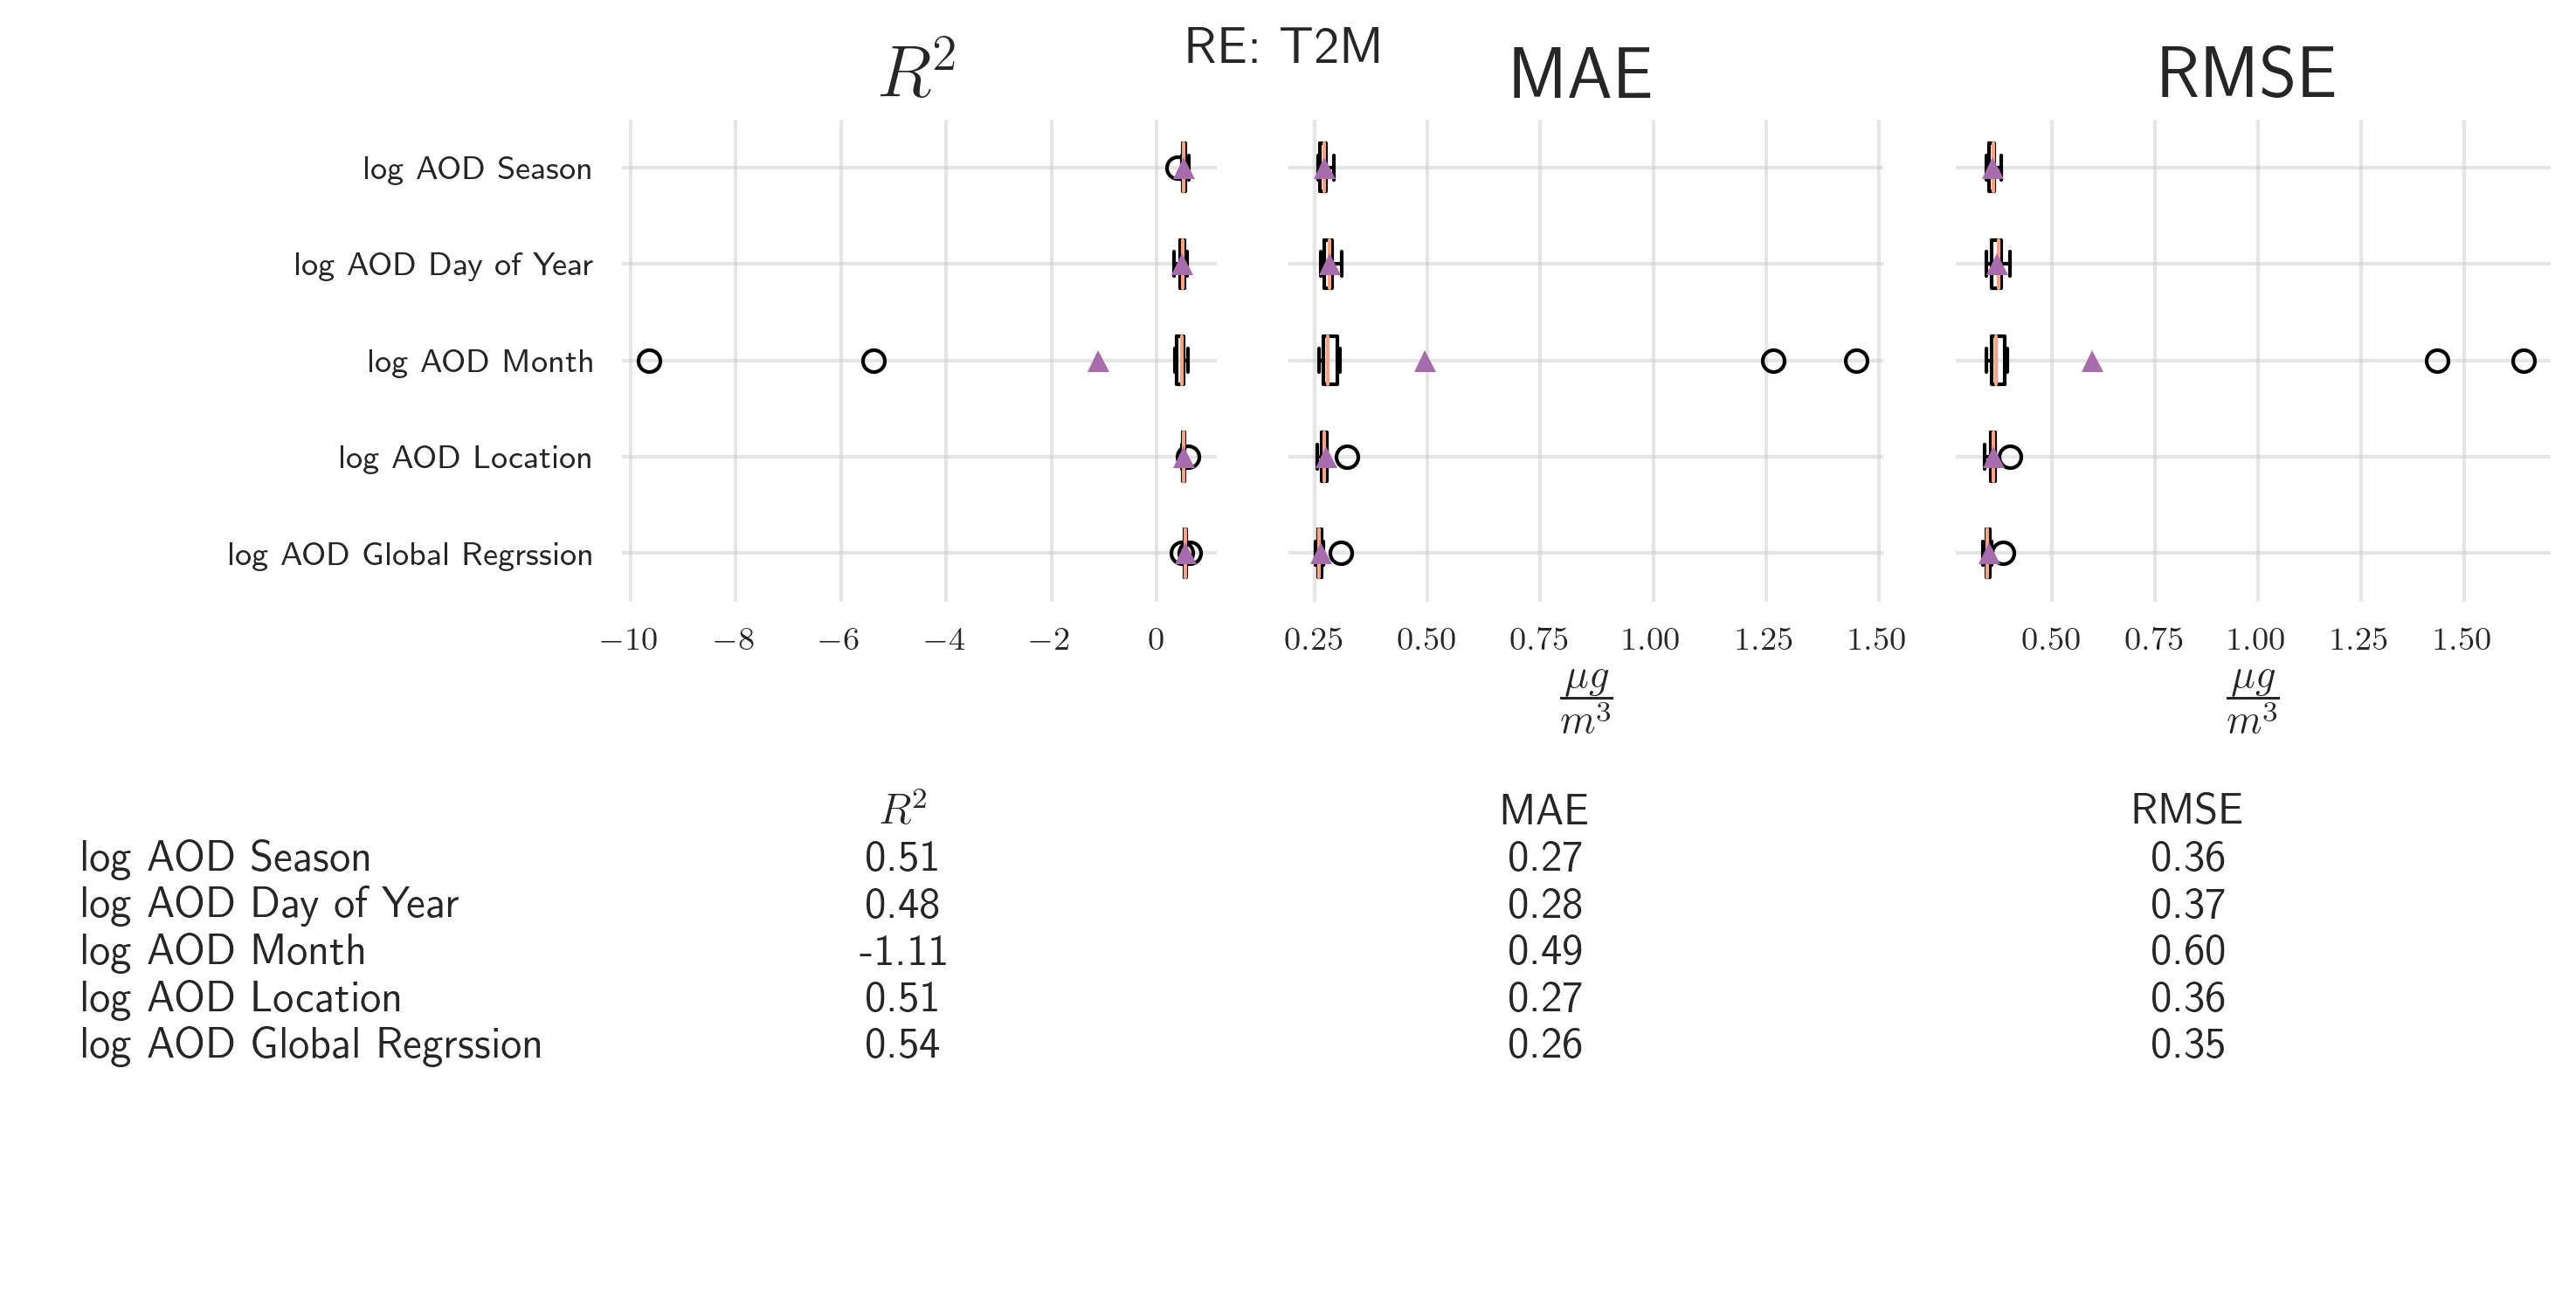

In [220]:
cv_scores = {}
# for grouping in ['season', 'doy', 'month', 'location']:
#     filename = os.path.join('models', 'lme', f'{save_prefix}{grouping}_scores.p')
#     with open(filename, 'rb') as f: 
#         scores = pickle.load(f)
#     title = grouping.capitalize()
#     if title == 'Doy':
#         title = 'Day of Year'
#     cv_scores[title] = scores['Linear Mixed Effect']
    
for grouping in ['season', 'doy', 'month', 'location']:
    filename = os.path.join('models', 'lme', f'{log_save_prefix}{grouping}_scores.p')
    with open(filename, 'rb') as f: 
        scores = pickle.load(f)
    title = grouping.capitalize()
    if title == 'Doy':
        title = 'Day of Year'
    title = 'log AOD ' + title
    cv_scores[title] = scores['Linear Mixed Effect']

# cv_scores['Global Regrssion'] = global_scores_reg["Linear Regression"]    
cv_scores['log AOD Global Regrssion'] = global_scores_log["Linear Regression"]    
    
labels, scores = map(list, zip(*cv_scores.items()))
fig, _ = grouped_boxplot_with_table(scores, labels, fs=9, save=True, filename='figures/lme_t2m_comparison.png')
fig.suptitle('RE: T2M');

In [140]:
empty = pd.Series([], dtype='float64')

mc = ModelCollection(empty, empty)

mc.load(os.path.join('models', 'lme', f'{log_save_prefix}season.joblib'))
mc.load_model_cross_val_scores(os.path.join('models', 'lme', f'{log_save_prefix}_scores.p'))

In [143]:
mc.models['Linear Mixed Effect'].summary()

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+LogAODANA+(1+LogAODANA|Location)+(1+LogAODANA|Season)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'Location': 207.0, 'Season': 4.0}

Log-likelihood: -161149.565 	 AIC: 322299.130

Random effects:

                 Name  Var  Std
Location  (Intercept) 0.02 0.14
Location    LogAODANA 0.00 0.07
Season    (Intercept) 0.10 0.32
Season      LogAODANA 0.01 0.11
Residual              0.10 0.32

                  IV1        IV2  Corr
Location  (Intercept)  LogAODANA  0.76
Season    (Intercept)  LogAODANA  0.96

Fixed effects:



Estimate  2.5_ci  97.5_ci   SE        DF  T-stat  P-val  Sig
(Intercept)     -0.03   -0.35     0.29 0.16      3.30   -0.19   0.86     
QV2M            20.74   13.65    27.84 3.62 603600.47    5.73   0.00  ***
QV10M           -9.58  -16.75    -2.40 3.66 603814.04   -2.62   0.01   **
T2M              0.03    0.03     0.04 0.00 602361.51   11.47   0.00  ***
T10M             0.03    0.03     0.04 0.00 603678.78   14.67   0.00  ***
TQV             -0.02   -0.02    -0.02 0.00 604219.40 -182.27   0.00  ***
LogAODANA        0.70    0.59     0.81 0.06      3.04   12.43   0.00   **
ALBEDO           0.19    0.12     0.26 0.04 319954.83    5.01   0.00  ***
TS              -0.05   -0.05    -0.05 0.00 599510.60  -53.11   0.00  ***
MonthCos        -0.03   -0.04    -0.03 0.00 596278.67  -17.72   0.00  ***
DISPH            0.01    0.00     0.01 0.00    246.37    3.36   0.00  ***

In [ ]:
cv_scores = mc.compute_cross_validation_scores()

  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-221-40343248d7fd>", line 194, in fit
    self.model_.fit()
  File "/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/pymer4/models/Lmer.py", line 421, in fit
    self.model_obj = lmer.lmer(
  File "/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/rpy2/robjects/functions.py", line 198, in __call__
    return (super(SignatureTranslatedFunction, self)
  File "/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/rpy2/robjects/functions.py", line 125, in __call__
    res = super(Function, self

In [30]:
fit_times = mc.fit()

  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Season)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 604854	 Groups: {'Season': 4.0}

Log-likelihood: -224875.384 	 AIC: 449750.768

Random effects:

                 Name  Var  Std
Season    (Intercept) 0.02 0.13
Season         AODANA 0.76 0.87
Residual              0.12 0.35

                IV1     IV2  Corr
Season  (Intercept)  AODANA -0.85

Fixed effects:

[13:07:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [117]:
mc.save(os.path.join('models', 'lme', 'texas-2010-17-season-aod-qv2m.joblib'))

In [64]:
mc.save_model_cross_val_scores(os.path.join('models', 'texas-2010-17-lme-seasons_log_aod_scores.p'))

In [31]:
mc.load(os.path.join('models', 'lme', 'texas-2010-17-season-aod-qv2m'))

In [421]:
mc.load_model_cross_val_scores(os.path.join('models', 'texas-2010-17-lme-seasons_scores.p'))

## Hyper Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params={
    'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4), DecisionTreeRegressor(max_depth=5)],
    'learning_rate': np.arange(0.5, 2, .1),
    'loss': ['linear', 'square', 'exponential'],
    'n_estimators': np.arange(10, 100, 10)
}

ada_grid = GridSearchCV(
    AdaBoostRegressor(), 
    params, 
    cv=10, 
    scoring=mc.scoring, 
    refit='neg_root_mean_squared_error',
    n_jobs=-1)

_x = x.copy()
ada_grid.fit(_x, y)

## Plotting

In [ ]:
model = mc.models['Linear Mixed Effect'].model_

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

model.plot("AODANA", plot_ci=True, ylabel="Predicted $\ln [PM2.5]$", ax=ax1)
model.plot("QV2M", plot_ci=True, ylabel="Predicted $\ln [PM2.5]$", ax=ax2)

ax1.set_ylim((-6, 6))
ax1.set_xlim((0, 2))

ax2.set_ylim((-6, -2.5))
ax2.set_xlim((0, .025))

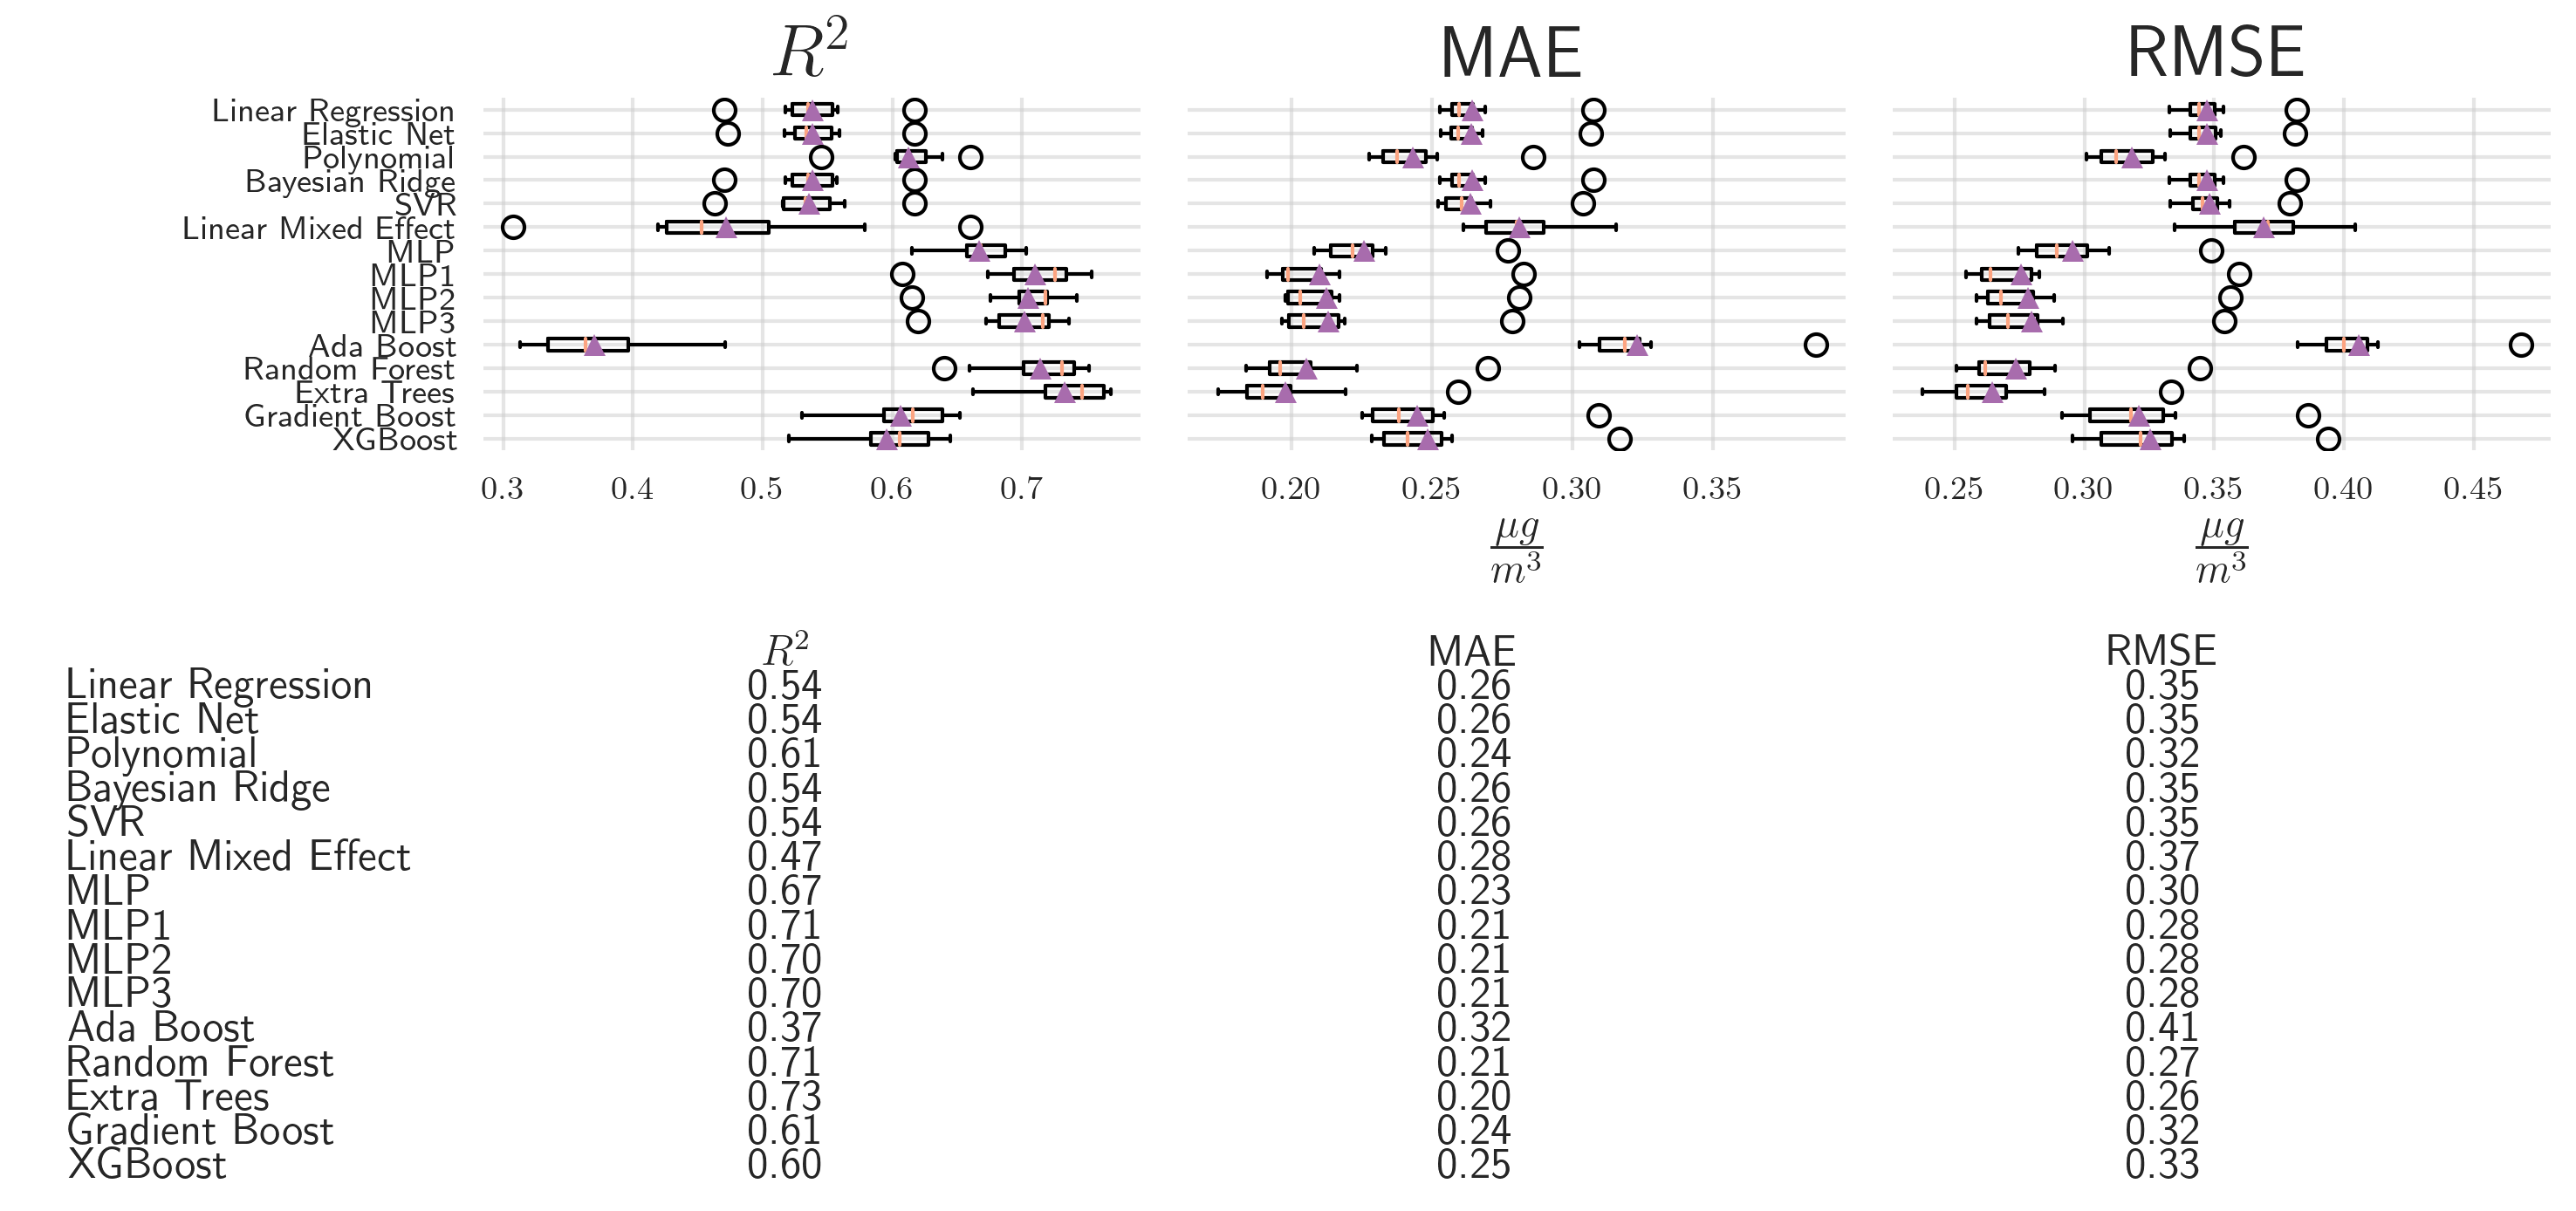

In [65]:
labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
grouped_boxplot_with_table(scores, labels, save=False, filename='scores-2010-17.png', fs=9)

In [ ]:
for name, model in mc.models.items():
    residuals_plot(model, x_train.copy(), y_train, x_val.copy(), y_val)

In [ ]:
for name, model in mc.models.items():
    plot_prediction_error(model, x_val.copy(), y_val, name=f'{name}')

In [100]:
selected_features = ds[['QV2M', 'QV10M', 'T2M', 'T10M', 'TQV', 'AODANA', 'ALBEDO', 'TS', 'DISPH', 'PM2.5']]
avgs = selected_features.resample(time='1Y').mean()

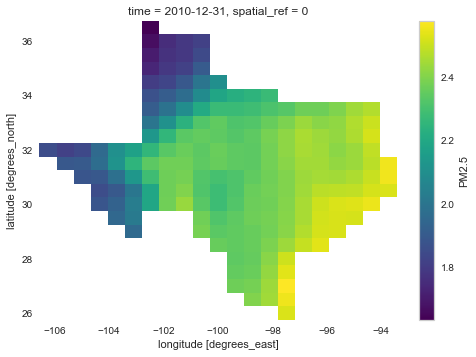

In [115]:
plt.rcParams.update({"text.usetex": False})

avgs[col].sel(time='2010').plot()

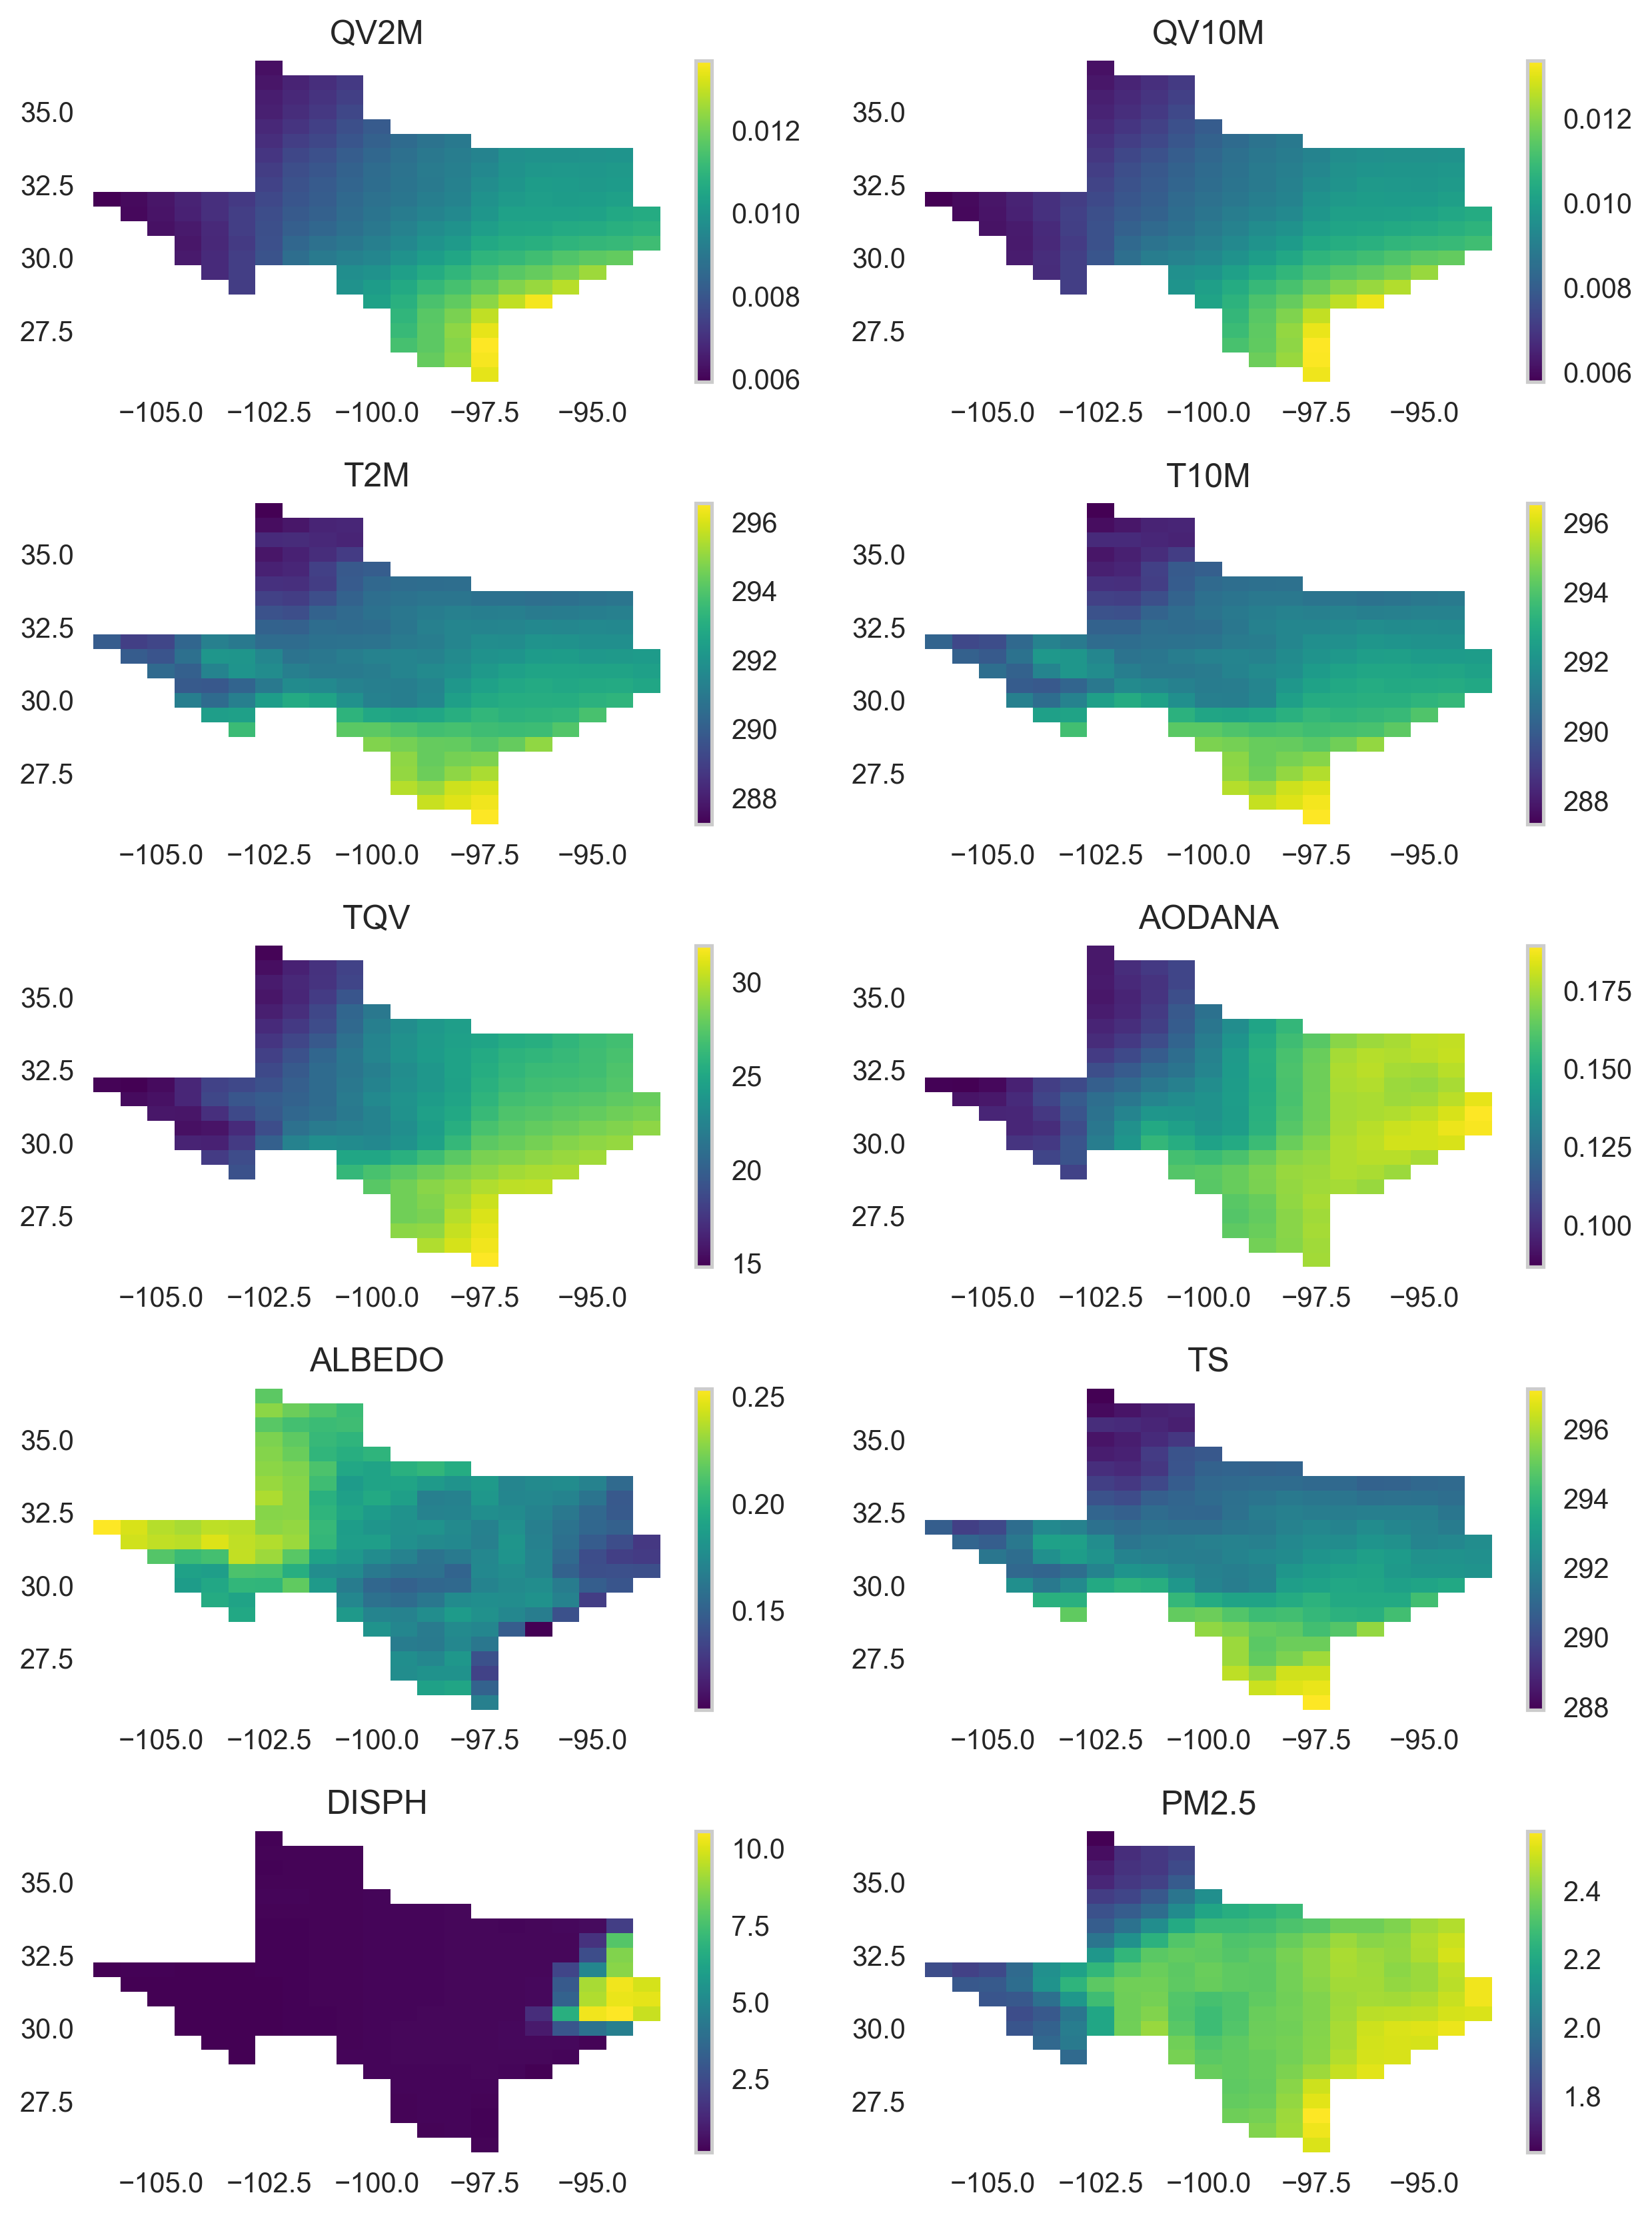

In [125]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=300, figsize=(8.5, 11.25))

for (col, data), ax in zip(avgs.data_vars.items(), axes.ravel()):
    data.sel(time='2010').plot(ax=ax, cbar_kwargs={'label': ''})
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
fig.tight_layout()

## Stacking

In [114]:
stack = ModelStack(mc, x_train, y_train, n = 3)

In [115]:
stack.fit()

In [116]:
stack.compute_scores(x_val, y_val)

{'r2': 0.6714344104686639,
 'rmse': 0.3221761221615988,
 'mae': 0.2437124185580695}

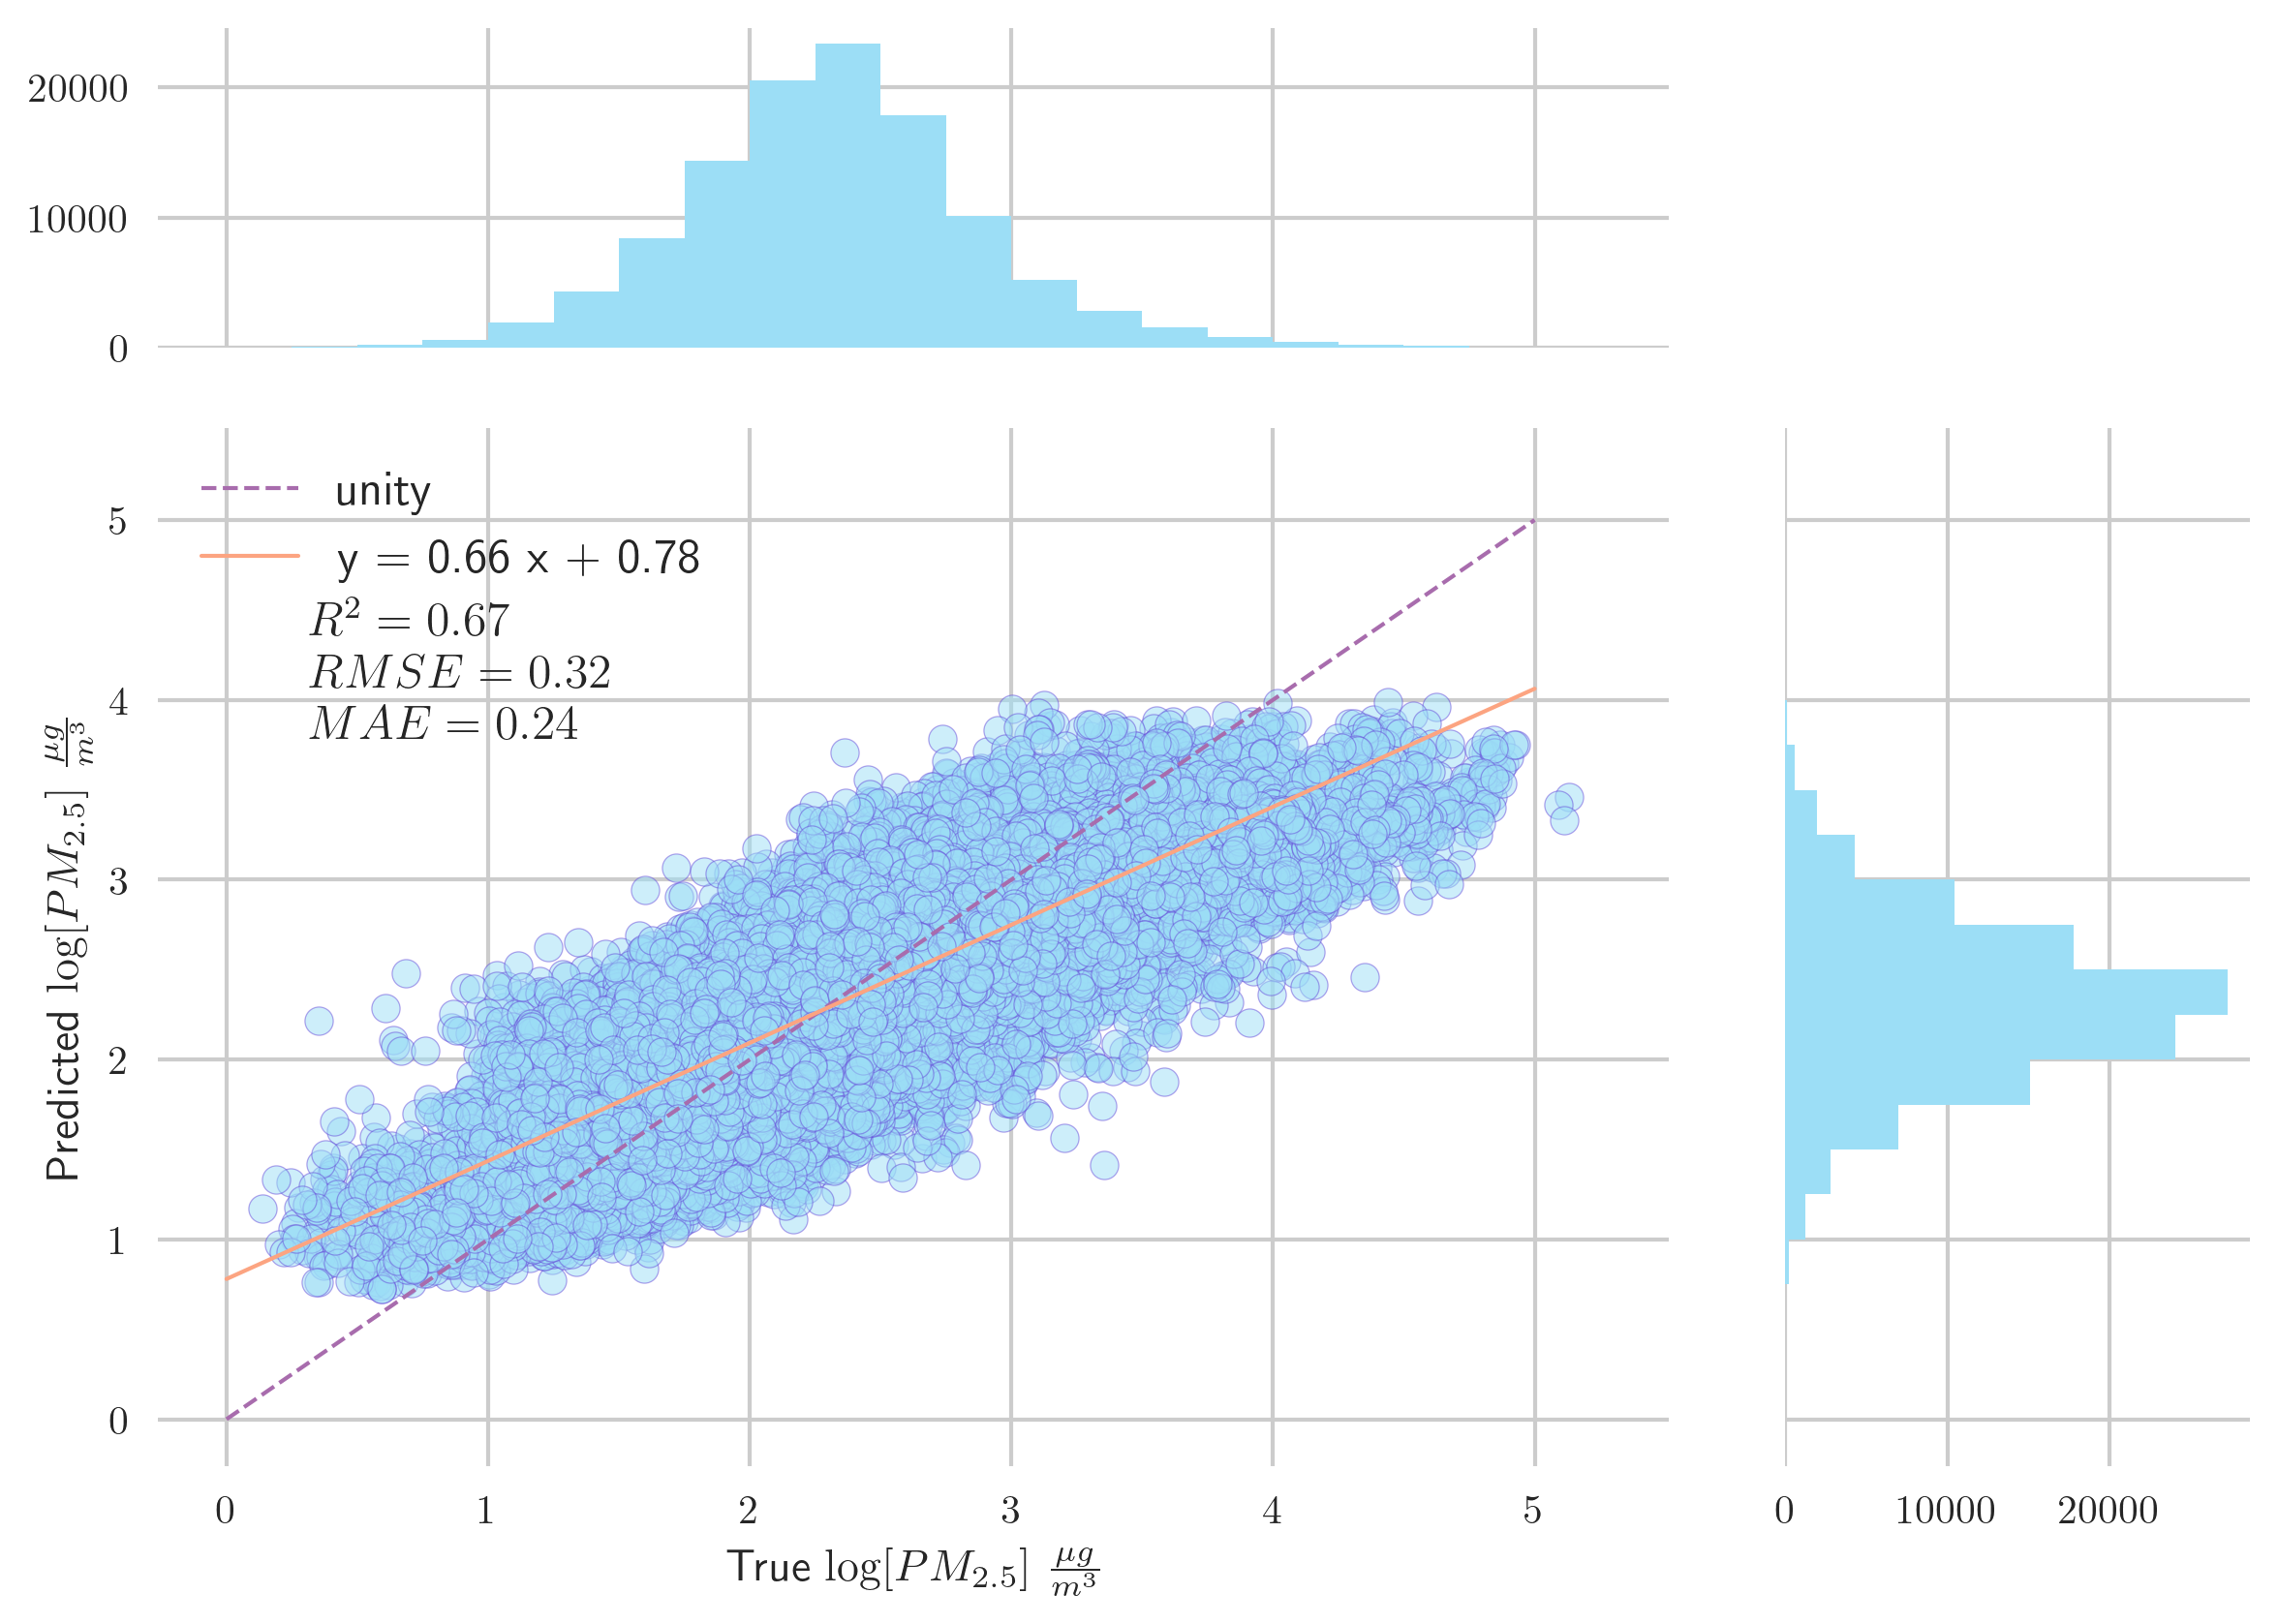

In [117]:
plot_prediction_error(stack.voting_regressor_, x_val.copy(), y_val)

In [118]:
stack.voting_regressor_

VotingRegressor(estimators=[('Extra Trees', ExtraTreesRegressor(n_jobs=-1)),
                            ('Random Forest', RandomForestRegressor(n_jobs=-1)),
                            ('MLP1',
                             Pipeline(steps=[('scaler', StandardScaler()),
                                             ('mlp',
                                              MLPRegressor(early_stopping=True,
                                                           hidden_layer_sizes=(100,
                                                                               100,
                                                                               100),
                                                           max_iter=100000))]))],
                n_jobs=-1)

## Feature Importance

In [ ]:
columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
for name, model in mc.models.items():
    if getattr(model, 'feature_importances_', None) is not None:
        feature_importance(mc.models[name].feature_importances_, name, columns, fontsize=18)
        plt.savefig(f'{name}-importances-log-new-features.png')

In [ ]:
columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
for name, model in mc.models.items():
    if getattr(model, 'coef_', None) is not None:
        feature_importance(mc.models[name].coef_, name, columns, fontsize=18)
        plt.savefig(f'{name}-importances-log-new-features.png')

In [ ]:
columns = np.array([c.replace('_cos', ' cosine').replace('_sin', ' sine') for c in x.columns.values])
importances = mc.models['Elastic Net'].named_steps['elastic'].coef_
feature_importance(importances, 'Elastic Net', columns, fontsize=18)
plt.savefig(f'Elastic Net-importances-log-new-features.png')

In [ ]:
importances = mc.models['Polynomial'].named_steps['linear'].coef_
mask = (importances > 0.1) | (importances < -0.1)
columns = mc.models['Polynomial'].named_steps['poly'].get_feature_names(x.columns.values)
columns = np.array([f'${c}$'.replace(" ", " \cdot ") for c in columns])
feature_importance(importances[mask], 'Polynomial', columns[mask], fontsize=10)
plt.savefig(f'Polynomial-importances-log-new-features.png')

# Modeling per grid cell

In [175]:
support = features.get_support()
# select lat, lon
support[0:2] = True

In [176]:
x_grid = train.drop('PM2.5', axis=1).loc[:, support]
y_grid = train[['PM2.5']]

In [177]:
train_grid = pd.concat([x_grid, y_grid], axis=1)

In [178]:
train_grid_2010 = train_grid.loc['2010']

In [179]:
train_grid_2011 = train_grid.loc['2011']

In [26]:
mcs = {}

lme_group = 'Month'
formula = f'PM ~ QV2M + QV10M + T2M + T10M + TQV + AODANA + (1 + AODANA|{lme_group}) + ALBEDO + TS + MonthCos + DISPH'

for location, data in train_grid_2010.groupby(['lat', 'lon']):
    _x, _y = data.drop(['lat', 'lon', 'PM2.5'], axis=1), data['PM2.5']
    _mc = ModelCollection(_x.copy(), 
                          _y,
                          lme_dependent='PM', 
                          lme_formula=formula, 
                          lme_group=lme_group)
    _mc.fit()
    location = str(location)
    _mc.save(f'models/locations_log_aod/{location}.joblib')
    mcs[location] = _mc

  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -22.540 	 AIC: 45.080

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.44 0.66
Month          AODANA 0.07 0.26
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model failed to converge with max|grad| = 0.00388921 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -8.418 	 AIC: 16.836

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.48 0.69
Month          AODANA 0.06 0.25
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 1.177 	 AIC: -2.353

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.45 0.67
Month          AODANA 0.06 0.24
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017263955394618336, tolerance: 0.008038195261816494
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -15.406 	 AIC: 30.812

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.45 0.67
Month          AODANA 0.06 0.24
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 3.131 	 AIC: -6.262

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.54 0.74
Month          AODANA 0.08 0.28
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -5.110 	 AIC: 10.220

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.42 0.65
Month          AODANA 0.06 0.24
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 0.778 	 AIC: -1.556

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.05 0.23
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -17.048 	 AIC: 34.096

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.37 0.61
Month          AODANA 0.05 0.23
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -11.050 	 AIC: 22.100

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.54 0.74
Month          AODANA 0.08 0.29
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model failed to converge with max|grad| = 0.0042257 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -14.130 	 AIC: 28.260

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.06 0.25
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -10.578 	 AIC: 21.156

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.37 0.61
Month          AODANA 0.06 0.24
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -20.254 	 AIC: 40.507

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.05 0.23
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00578372504286051, tolerance: 0.0057347697562074
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -12.788 	 AIC: 25.575

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.57 0.76
Month          AODANA 0.09 0.30
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:36:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -19.291 	 AIC: 38.583

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.45 0.67
Month          AODANA 0.07 0.27
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:37:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -16.243 	 AIC: 32.486

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.36 0.60
Month          AODANA 0.06 0.25
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -29.453 	 AIC: 58.906

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.39 0.62
Month          AODANA 0.08 0.28
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005901152152993916, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006108764299341374, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006197185075670575, tolerance: 0.0052570887187003736
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -1.816 	 AIC: 3.633

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.51 0.71
Month          AODANA 0.08 0.29
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:37:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -18.211 	 AIC: 36.421

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.55 0.74
Month          AODANA 0.09 0.30
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:37:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -27.715 	 AIC: 55.430

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.46 0.68
Month          AODANA 0.07 0.27
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:37:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -22.580 	 AIC: 45.161

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.37 0.61
Month          AODANA 0.06 0.24
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:37:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -44.635 	 AIC: 89.270

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.40 0.63
Month          AODANA 0.07 0.26
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:37:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -55.519 	 AIC: 111.038

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.47 0.69
Month          AODANA 0.06 0.24
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:37:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -44.409 	 AIC: 88.817

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.35 0.59
Month          AODANA 0.06 0.23
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model failed to converge with max|grad| = 0.00374635 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 57.127 	 AIC: -114.253

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.03 0.17
Residual              0.04 0.19

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006203226511011906, tolerance: 0.004942079167162733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006446247733229882, tolerance: 0.004942079167162733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00933638086385713, tolerance: 0.0052822626635785986
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 19.006 	 AIC: -38.011

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.39 0.62
Month          AODANA 0.07 0.27
Residual              0.04 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 0.488 	 AIC: -0.976

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.52 0.72
Month          AODANA 0.09 0.30
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:37:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05592704793404479, tolerance: 0.005975193788924244
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -16.182 	 AIC: 32.364

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.49 0.70
Month          AODANA 0.08 0.28
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:38:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -26.448 	 AIC: 52.896

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.47 0.69
Month          AODANA 0.07 0.26
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:38:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -34.985 	 AIC: 69.971

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.44 0.67
Month          AODANA 0.06 0.25
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:38:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -52.803 	 AIC: 105.606

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.42 0.65
Month          AODANA 0.06 0.25
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:38:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -49.848 	 AIC: 99.697

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.44 0.66
Month          AODANA 0.05 0.23
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:38:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01533631411606251, tolerance: 0.0075703690813022995
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -27.183 	 AIC: 54.365

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.44 0.66
Month          AODANA 0.04 0.19
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:38:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0230175489603468, tolerance: 0.00840644841363447
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model failed to converge with max|grad| = 0.00263032 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -47.316 	 AIC: 94.633

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.03 0.16
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:38:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 50.918 	 AIC: -101.835

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.48
Month          AODANA 0.03 0.16
Residual              0.04 0.20

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:38:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 60.094 	 AIC: -120.188

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.44
Month          AODANA 0.02 0.15
Residual              0.04 0.19

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:38:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 7.473 	 AIC: -14.945

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.35 0.59
Month          AODANA 0.07 0.27
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:38:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048874899099960345, tolerance: 0.005819260233263103
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -11.584 	 AIC: 23.168

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.39 0.62
Month          AODANA 0.07 0.27
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:38:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -17.125 	 AIC: 34.251

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.36 0.60
Month          AODANA 0.06 0.25
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:38:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02090279021997432, tolerance: 0.006372111767533096
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -23.832 	 AIC: 47.664

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.34 0.59
Month          AODANA 0.05 0.23
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:38:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -41.066 	 AIC: 82.132

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.40 0.63
Month          AODANA 0.06 0.25
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:38:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024639922474129605, tolerance: 0.007622663068095334
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -49.553 	 AIC: 99.107

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.06 0.25
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:39:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -39.138 	 AIC: 78.276

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.45 0.67
Month          AODANA 0.06 0.23
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:39:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02172590349366388, tolerance: 0.007329127010882117
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -27.506 	 AIC: 55.012

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.39 0.62
Month          AODANA 0.04 0.19
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:39:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -34.345 	 AIC: 68.691

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.01 0.12
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:39:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018669927340638992, tolerance: 0.008695086228596487
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -64.906 	 AIC: 129.812

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.20 0.44
Month          AODANA 0.01 0.12
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:39:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 22.957 	 AIC: -45.915

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.28 0.53
Month          AODANA 0.04 0.20
Residual              0.04 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:39:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 20.061 	 AIC: -40.123

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.03 0.17
Residual              0.05 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:39:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 24.423 	 AIC: -48.847

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.43
Month          AODANA 0.03 0.16
Residual              0.04 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:39:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 38.671 	 AIC: -77.342

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.48
Month          AODANA 0.04 0.21
Residual              0.04 0.20

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:39:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 43.666 	 AIC: -87.331

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.20 0.44
Month          AODANA 0.05 0.22
Residual              0.04 0.20

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:39:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 36.006 	 AIC: -72.013

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.06 0.25
Residual              0.04 0.20

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:39:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -1.172 	 AIC: 2.344

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.33 0.58
Month          AODANA 0.07 0.27
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:39:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -19.621 	 AIC: 39.243

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.34 0.59
Month          AODANA 0.06 0.25
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:39:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.058028368559075005, tolerance: 0.005950910291382434
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -15.533 	 AIC: 31.067

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.55
Month          AODANA 0.05 0.22
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:39:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0679686549043339, tolerance: 0.006444782363705949
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -30.072 	 AIC: 60.144

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.54
Month          AODANA 0.04 0.21
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:40:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08463915016914214, tolerance: 0.0067863773665366054
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -40.971 	 AIC: 81.942

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.34 0.59
Month          AODANA 0.05 0.23
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:40:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05672945618480796, tolerance: 0.007202154022040422
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -38.579 	 AIC: 77.157

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.07 0.26
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:40:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007727169628097386, tolerance: 0.00735100601068726
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -38.482 	 AIC: 76.965

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.06 0.24
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:40:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -36.803 	 AIC: 73.606

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.32 0.57
Month          AODANA 0.04 0.20
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.86

Fixed effects:

[10:40:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0066825053240009424, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006796141089807861, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067110434035484445, tolerance: 0.0065594521580171075
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Document

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -44.082 	 AIC: 88.164

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.17 0.42
Month          AODANA 0.01 0.12
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.70

Fixed effects:

[10:40:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008762043835425004, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008885600071955935, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008762693080910822, tolerance: 0.00731993410098467
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -81.597 	 AIC: 163.195

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.12 0.35
Month          AODANA 0.01 0.08
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.31

Fixed effects:

[10:40:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009936203716598868, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009886472142945024, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009658833915132448, tolerance: 0.008605214170540368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -126.020 	 AIC: 252.039

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.14 0.37
Month          AODANA 0.01 0.09
Residual              0.10 0.32

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.47

Fixed effects:

[10:40:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 6.191 	 AIC: -12.383

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.04 0.20
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:40:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 6.479 	 AIC: -12.959

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.46
Month          AODANA 0.02 0.15
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:40:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 6.405 	 AIC: -12.810

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.16 0.41
Month          AODANA 0.02 0.14
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:40:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 18.411 	 AIC: -36.821

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.48
Month          AODANA 0.04 0.20
Residual              0.05 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:40:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 20.389 	 AIC: -40.777

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.46
Month          AODANA 0.05 0.23
Residual              0.04 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:40:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 14.140 	 AIC: -28.281

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.46
Month          AODANA 0.06 0.24
Residual              0.05 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:40:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -1.613 	 AIC: 3.226

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.54
Month          AODANA 0.07 0.26
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:41:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -8.649 	 AIC: 17.298

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.36 0.60
Month          AODANA 0.06 0.25
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:41:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -6.671 	 AIC: 13.341

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.55
Month          AODANA 0.05 0.21
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:41:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -25.461 	 AIC: 50.922

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.25 0.50
Month          AODANA 0.04 0.20
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:41:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03992734657447983, tolerance: 0.006393267539341953
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model failed to converge with max|grad| = 0.00232705 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -27.104 	 AIC: 54.207

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.39 0.62
Month          AODANA 0.06 0.24
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:41:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09635936258948163, tolerance: 0.0068577687236111365
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -26.030 	 AIC: 52.061

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.40 0.64
Month          AODANA 0.07 0.26
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:41:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -37.041 	 AIC: 74.081

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.38 0.61
Month          AODANA 0.06 0.24
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:41:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009038370665805928, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009258496054691534, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00927034370365476, tolerance: 0.007225715006804859
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -43.799 	 AIC: 87.598

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.28 0.53
Month          AODANA 0.04 0.20
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.89

Fixed effects:

[10:41:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00759624797870373, tolerance: 0.007439626376809449
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01262277808017842, tolerance: 0.008068508768445089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012499976568001614, tolerance: 0.008068508768445089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -77.779 	 AIC: 155.558

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.20 0.45
Month          AODANA 0.02 0.16
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.74

Fixed effects:

[10:41:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -121.345 	 AIC: 242.691

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.12 0.35
Month          AODANA 0.01 0.12
Residual              0.10 0.31

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.25

Fixed effects:

[10:41:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011890372699660645, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01171167784436733, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011339774396446956, tolerance: 0.010005723475594112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -157.591 	 AIC: 315.181

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.15 0.39
Month          AODANA 0.01 0.12
Residual              0.12 0.35

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.23

Fixed effects:

[10:41:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010864070486569233, tolerance: 0.009542186289597682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010208007387554119, tolerance: 0.009542186289597682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1615859192027358, tolerance: 0.011280918527584248
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -159.528 	 AIC: 319.055

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.15 0.39
Month          AODANA 0.01 0.09
Residual              0.12 0.35

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.22

Fixed effects:

[10:41:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 11.584 	 AIC: -23.168

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.35 0.59
Month          AODANA 0.04 0.21
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:41:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 7.031 	 AIC: -14.062

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.03 0.17
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:42:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 32.495 	 AIC: -64.990

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.15 0.39
Month          AODANA 0.02 0.13
Residual              0.04 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005486342416979539, tolerance: 0.004732619325557005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005860897274367005, tolerance: 0.004732619325557005
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005086240978807055, tolerance: 0.004583384953279139
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Model failed to converge with max|grad| = 0.00248653 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 43.427 	 AIC: -86.854

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.42
Month          AODANA 0.03 0.16
Residual              0.04 0.20

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005610315938088917, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005619846043803278, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005481560679246655, tolerance: 0.00482819312639825
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 27.237 	 AIC: -54.473

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.20 0.45
Month          AODANA 0.04 0.20
Residual              0.04 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:42:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006542731444653782, tolerance: 0.0055192340712876525
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 1.728 	 AIC: -3.455

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.16 0.40
Month          AODANA 0.04 0.20
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:42:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00593557424915403, tolerance: 0.005220210149938682
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005751917732258249, tolerance: 0.005390567337798101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0058488422636848725, tolerance: 0.005390567337798101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -3.034 	 AIC: 6.069

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.43
Month          AODANA 0.05 0.22
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -6.648 	 AIC: 13.295

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.06 0.24
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:42:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -4.713 	 AIC: 9.426

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.55
Month          AODANA 0.06 0.23
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:42:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007001591212116409, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071021028767255245, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071174274315879416, tolerance: 0.005067440526426438
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -6.209 	 AIC: 12.418

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.48
Month          AODANA 0.04 0.21
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:42:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -12.955 	 AIC: 25.910

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.46
Month          AODANA 0.04 0.19
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.92

Fixed effects:

[10:42:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -4.689 	 AIC: 9.378

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.35 0.59
Month          AODANA 0.05 0.23
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:42:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13440357941568237, tolerance: 0.006518613867154475
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -13.509 	 AIC: 27.018

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.55
Month          AODANA 0.05 0.23
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:42:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -25.988 	 AIC: 51.976

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.06 0.24
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:42:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007766218048850249, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00786953210267427, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007871735680325287, tolerance: 0.007177234173889617
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -43.114 	 AIC: 86.228

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.06 0.23
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:43:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009089475071803577, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012177398522993599, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01367479641014313, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013381494652222159, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01889058632044538, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025830629261982097, tolerance: 0.008110268090491281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -95.398 	 AIC: 190.797

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.33 0.57
Month          AODANA 0.04 0.19
Residual              0.09 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.91

Fixed effects:

[10:43:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011062220377723975, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011319376393856828, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009745065930268026, tolerance: 0.009173652703559776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -142.101 	 AIC: 284.202

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.32 0.57
Month          AODANA 0.03 0.16
Residual              0.11 0.33

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.87

Fixed effects:

[10:43:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012187134784845455, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016506408668504946, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016984683351687124, tolerance: 0.010167904007036679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -177.512 	 AIC: 355.024

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.47
Month          AODANA 0.03 0.16
Residual              0.14 0.37

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.62

Fixed effects:

[10:43:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011859437187254684, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011739232643861897, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011496017058988173, tolerance: 0.010788129441522668
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013348773726121976, tolerance: 0.011945841903728377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025245745380175322, tolerance: 0.011945841903728377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026397922438064825, tolerance: 0.011945841903728377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -209.558 	 AIC: 419.116

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.43
Month          AODANA 0.00 0.02
Residual              0.17 0.41

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:43:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -1.039 	 AIC: 2.078

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.39 0.62
Month          AODANA 0.05 0.22
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:43:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 4.800 	 AIC: -9.600

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.32 0.57
Month          AODANA 0.04 0.20
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:43:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017144972352326704, tolerance: 0.005239026523052261
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 24.663 	 AIC: -49.326

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.44
Month          AODANA 0.03 0.16
Residual              0.05 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:43:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04618885448911314, tolerance: 0.00502269523580531
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 45.651 	 AIC: -91.302

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.16 0.40
Month          AODANA 0.02 0.15
Residual              0.04 0.20

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:43:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04771040840251928, tolerance: 0.005249487596680164
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 28.820 	 AIC: -57.640

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.43
Month          AODANA 0.03 0.18
Residual              0.04 0.21

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:43:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07114754104080134, tolerance: 0.005557820784922568
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 8.597 	 AIC: -17.194

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.13 0.36
Month          AODANA 0.03 0.18
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:43:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006089808296945165, tolerance: 0.005286688513649417
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005662821633961812, tolerance: 0.00531716214223906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006125326053712854, tolerance: 0.00531716214223906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -10.564 	 AIC: 21.129

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.14 0.38
Month          AODANA 0.03 0.17
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:43:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00673038378787183, tolerance: 0.005025904687024401
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005206496437828889, tolerance: 0.005091098137864351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005313797513124996, tolerance: 0.005091098137864351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5304288020625805, tolerance: 0.005863364642332474
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -11.958 	 AIC: 23.915

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.14 0.37
Month          AODANA 0.03 0.18
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:44:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -9.773 	 AIC: 19.545

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.44
Month          AODANA 0.04 0.21
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:44:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005229724729346685, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005409808470986377, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005521720762164506, tolerance: 0.004875075526147377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -3.295 	 AIC: 6.590

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.22 0.47
Month          AODANA 0.05 0.22
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -7.366 	 AIC: 14.732

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.43
Month          AODANA 0.04 0.20
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:44:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -13.316 	 AIC: 26.633

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.43
Month          AODANA 0.03 0.18
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:44:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -5.198 	 AIC: 10.396

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.04 0.20
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:44:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030936819981349117, tolerance: 0.006347314147745285
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -11.349 	 AIC: 22.699

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.04 0.20
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:44:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -23.062 	 AIC: 46.125

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.41 0.64
Month          AODANA 0.06 0.24
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:44:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007549126277005769, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007681208533909967, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010349183479881674, tolerance: 0.007343177410237883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -49.803 	 AIC: 99.607

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.45 0.67
Month          AODANA 0.06 0.25
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:44:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00857591428825799, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009480937429842129, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01040549327205298, tolerance: 0.008144928592353268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -96.664 	 AIC: 193.329

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.43 0.65
Month          AODANA 0.05 0.23
Residual              0.09 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:44:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00891206302541292, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014026402181762876, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014429913142450346, tolerance: 0.008877265952040119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -142.039 	 AIC: 284.078

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.48 0.69
Month          AODANA 0.04 0.20
Residual              0.11 0.34

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:44:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010145307917646562, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011254740250613793, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016121505048907636, tolerance: 0.010010033563258018
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -182.408 	 AIC: 364.815

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.35 0.59
Month          AODANA 0.02 0.15
Residual              0.14 0.38

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:44:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015509467848261238, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01914084997568466, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019931188782990716, tolerance: 0.011919523808414902
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -215.673 	 AIC: 431.345

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.25 0.50
Month          AODANA 0.01 0.09
Residual              0.17 0.42

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:45:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -12.952 	 AIC: 25.903

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.28 0.53
Month          AODANA 0.04 0.19
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:45:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -31.806 	 AIC: 63.613

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.04 0.20
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:45:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -15.444 	 AIC: 30.887

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.28 0.53
Month          AODANA 0.03 0.18
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:45:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011499366397710986, tolerance: 0.006451367818988432
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 17.074 	 AIC: -34.148

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.45
Month          AODANA 0.03 0.17
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:45:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009693251343719567, tolerance: 0.006331524543675675
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: 11.747 	 AIC: -23.494

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.22 0.47
Month          AODANA 0.04 0.19
Residual              0.05 0.22

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:45:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -22.270 	 AIC: 44.540

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.43
Month          AODANA 0.03 0.18
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:45:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -24.892 	 AIC: 49.785

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.10 0.32
Month          AODANA 0.02 0.14
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:45:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005865285825894517, tolerance: 0.005773065463787696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006120448506820253, tolerance: 0.005773065463787696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006285136774085487, tolerance: 0.005940331123284464
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -20.402 	 AIC: 40.803

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.11 0.34
Month          AODANA 0.02 0.14
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:45:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007941395519303285, tolerance: 0.005240912577860033
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005908397826321021, tolerance: 0.005326674050582533
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006375555238221864, tolerance: 0.005326674050582533
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4920610283048781, tolerance: 0.006076396979994301
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -15.101 	 AIC: 30.202

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.11 0.34
Month          AODANA 0.02 0.15
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:45:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005570642486368627, tolerance: 0.005245908160673422
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04984509896498679, tolerance: 0.005631886366156586
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -13.650 	 AIC: 27.300

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.14 0.38
Month          AODANA 0.03 0.17
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:45:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006279603529737443, tolerance: 0.005201873606065792
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005225592668892887, tolerance: 0.005016430424303221
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00561827726961539, tolerance: 0.005016430424303221
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -18.751 	 AIC: 37.503

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.11 0.34
Month          AODANA 0.03 0.17
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:45:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055652563154531265, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005738613784242119, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005846859568766405, tolerance: 0.005286416413894226
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -25.108 	 AIC: 50.217

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.11 0.33
Month          AODANA 0.03 0.17
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:45:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -30.569 	 AIC: 61.138

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.12 0.35
Month          AODANA 0.02 0.14
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:45:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -12.124 	 AIC: 24.247

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.55
Month          AODANA 0.03 0.16
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:46:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006716827433670858, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006645481642507889, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00650448729281905, tolerance: 0.006159656714797865
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -6.199 	 AIC: 12.398

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.28 0.53
Month          AODANA 0.04 0.19
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:46:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20842941618681365, tolerance: 0.0068588829073802406
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -18.834 	 AIC: 37.669

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.36 0.60
Month          AODANA 0.05 0.22
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:46:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0071455669083704265, tolerance: 0.006514233279643029
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007932100576510948, tolerance: 0.006554226333080977
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015442075233281116, tolerance: 0.007314992904614687
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -57.083 	 AIC: 114.166

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.45 0.67
Month          AODANA 0.07 0.26
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:46:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011056358614858652, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011739715946426088, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01209046455691265, tolerance: 0.008217286386834284
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -95.070 	 AIC: 190.140

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.46 0.68
Month          AODANA 0.06 0.24
Residual              0.09 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:46:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008947630388568939, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009951830292415309, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011001612224951884, tolerance: 0.008614160491558245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -142.065 	 AIC: 284.129

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.40 0.63
Month          AODANA 0.03 0.18
Residual              0.11 0.34

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:46:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010193500163666158, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012434957877076158, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012523660313021878, tolerance: 0.009968299566396579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -184.194 	 AIC: 368.388

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.02 0.15
Residual              0.14 0.38

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:46:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -52.424 	 AIC: 104.848

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.06 0.24
Month          AODANA 0.00 0.06
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:46:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007199775772797068, tolerance: 0.007121661299849264
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0072373935935310385, tolerance: 0.007121661299849264
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -43.216 	 AIC: 86.432

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.06 0.24
Month          AODANA 0.01 0.08
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.90

Fixed effects:

[10:46:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006724268721622906, tolerance: 0.005927976158490512
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006074853596111041, tolerance: 0.0059281010503784625
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006342429308915598, tolerance: 0.0059281010503784625
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/P

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6489811258114528, tolerance: 0.006852963383170087
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -25.584 	 AIC: 51.168

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.09 0.30
Month          AODANA 0.01 0.12
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.92

Fixed effects:

[10:46:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006344319106577956, tolerance: 0.00527597511480843
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006414393491279924, tolerance: 0.0053905043508186016
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006805149316900128, tolerance: 0.005421673810839912
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005390754616318105, tolerance: 0.005353333920047535
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005647676639853216, tolerance: 0.005353333920047535
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005824925739535303, tolerance: 0.005353333920047535
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -22.534 	 AIC: 45.069

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.11 0.34
Month          AODANA 0.02 0.14
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:46:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006019187955985217, tolerance: 0.005313353662490148
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0068592753068408285, tolerance: 0.005507918937292674
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005570560197931229, tolerance: 0.005476043115595099
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47815847448385185, tolerance: 0.006227195856212316
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -38.742 	 AIC: 77.483

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.09 0.31
Month          AODANA 0.02 0.14
Residual              0.07 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:47:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -46.523 	 AIC: 93.046

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.09 0.30
Month          AODANA 0.02 0.15
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:47:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -49.300 	 AIC: 98.601

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.12 0.35
Month          AODANA 0.02 0.14
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:47:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -20.156 	 AIC: 40.312

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.47
Month          AODANA 0.02 0.15
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:47:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05747240086872907, tolerance: 0.0067443857175496875
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -7.585 	 AIC: 15.169

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.27 0.52
Month          AODANA 0.03 0.18
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:47:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1570165678400457, tolerance: 0.007047751022005929
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -11.752 	 AIC: 23.504

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.04 0.20
Residual              0.05 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:47:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -59.798 	 AIC: 119.595

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.33 0.57
Month          AODANA 0.04 0.20
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:47:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010630169275493984, tolerance: 0.008579997955138053
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007822331105970193, tolerance: 0.007789681143480599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008109086542390287, tolerance: 0.007789681143480599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -101.698 	 AIC: 203.396

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.32 0.57
Month          AODANA 0.04 0.20
Residual              0.09 0.30

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:47:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009962309235021394, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012986276913601102, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01455858751871375, tolerance: 0.009633412337452369
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011397265001264145, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012053582291144949, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012459289381965277, tolerance: 0.009454583327729584
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011132306673815151, tolerance: 0.007984005096015084
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01172235846290448, tolerance: 0.007984005096015084
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011963192054253113, tolerance: 0.007984005096015084
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -158.111 	 AIC: 316.223

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.55
Month          AODANA 0.03 0.16
Residual              0.12 0.35

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:47:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012422798532611523, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012268208388348967, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012017741683266081, tolerance: 0.011832876238907077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -196.748 	 AIC: 393.495

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.28 0.53
Month          AODANA 0.03 0.16
Residual              0.15 0.39

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:47:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -68.996 	 AIC: 137.992

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.07 0.26
Month          AODANA 0.00 0.05
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:47:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -68.377 	 AIC: 136.754

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.10 0.31
Month          AODANA 0.01 0.08
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:47:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076965560222319596, tolerance: 0.00737067658143229
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008062997472617184, tolerance: 0.007528774694451073
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00832377673319229, tolerance: 0.007528774694451073
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -50.137 	 AIC: 100.275

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.12 0.35
Month          AODANA 0.01 0.12
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:47:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0064445734051545855, tolerance: 0.006270061335615926
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007001616424361146, tolerance: 0.006379787706563678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007395532968303087, tolerance: 0.006379787706563678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008884932094979092, tolerance: 0.006947142960585666
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007255023949085171, tolerance: 0.00680325818079524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007599039390669304, tolerance: 0.00680325818079524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -40.959 	 AIC: 81.917

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.15 0.39
Month          AODANA 0.02 0.14
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:47:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006035511176172292, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00849488084764971, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008939376105221442, tolerance: 0.005764586256877484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006374667476741536, tolerance: 0.005767293110108435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008335789533099103, tolerance: 0.005767293110108435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008978314815482946, tolerance: 0.005767293110108435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006417065953247203, tolerance: 0.005756198965993996
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006750788982785139, tolerance: 0.005756198965993996
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007013911963994701, tolerance: 0.005756198965993996
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -50.139 	 AIC: 100.279

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.44
Month          AODANA 0.03 0.17
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:48:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006518198515983897, tolerance: 0.005890762465802838
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0059437956678998205, tolerance: 0.005874028229319686
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006377651721649613, tolerance: 0.005874028229319686
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -56.005 	 AIC: 112.009

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.44
Month          AODANA 0.03 0.18
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:48:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -60.146 	 AIC: 120.291

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.43
Month          AODANA 0.03 0.17
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:48:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011213597724285762, tolerance: 0.006445229888146498
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -31.762 	 AIC: 63.525

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.25 0.50
Month          AODANA 0.03 0.17
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:48:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -17.074 	 AIC: 34.147

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.55
Month          AODANA 0.03 0.18
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:48:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007652791716836305, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007670951265357218, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007531679599097174, tolerance: 0.006707165558492337
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -15.886 	 AIC: 31.772

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.55
Month          AODANA 0.04 0.20
Residual              0.06 0.23

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:48:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009193276019040297, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009407604555399018, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009425785902109851, tolerance: 0.00781608147641875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -56.254 	 AIC: 112.509

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.03 0.17
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:48:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011726555177595799, tolerance: 0.00876424704223544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014067910662184602, tolerance: 0.00876424704223544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0116807161093746, tolerance: 0.00799337866729679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -99.843 	 AIC: 199.686

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.48
Month          AODANA 0.03 0.16
Residual              0.09 0.30

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:48:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01212859042490777, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017550089801709134, tolerance: 0.009138094861256113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01687109446272217, tolerance: 0.009307549536093836
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020402682115737036, tolerance: 0.009216220633545167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020342907182943293, tolerance: 0.009216220633545167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -159.991 	 AIC: 319.982

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.30 0.55
Month          AODANA 0.03 0.16
Residual              0.13 0.35

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:48:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02010685840561166, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020330671359907626, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01996939623298033, tolerance: 0.012014819551607917
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -185.251 	 AIC: 370.501

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.22 0.47
Month          AODANA 0.01 0.12
Residual              0.14 0.38

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:48:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -81.424 	 AIC: 162.847

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.07 0.26
Month          AODANA 0.00 0.05
Residual              0.08 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:48:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -82.390 	 AIC: 164.780

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.10 0.32
Month          AODANA 0.01 0.08
Residual              0.08 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:48:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -74.933 	 AIC: 149.866

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.16 0.41
Month          AODANA 0.01 0.12
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:48:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010678716053771353, tolerance: 0.008592900228304598
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -59.746 	 AIC: 119.491

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.16 0.41
Month          AODANA 0.02 0.12
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:49:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010468070958715714, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01179072256893221, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012030182058232697, tolerance: 0.006413728751133654
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -60.834 	 AIC: 121.669

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.46
Month          AODANA 0.03 0.16
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:49:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -59.598 	 AIC: 119.196

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.29 0.54
Month          AODANA 0.05 0.22
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:49:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -66.172 	 AIC: 132.344

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.25 0.50
Month          AODANA 0.04 0.21
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:49:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -41.802 	 AIC: 83.604

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.26 0.51
Month          AODANA 0.03 0.17
Residual              0.07 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:49:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013743603698916473, tolerance: 0.006970046111822598
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -37.470 	 AIC: 74.941

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.03 0.18
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:49:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008079380656401014, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008027346564972504, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007903571423941713, tolerance: 0.007687047776891248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -38.693 	 AIC: 77.387

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.55
Month          AODANA 0.04 0.20
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:49:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010973653448782983, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01452583487086656, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015289679485682939, tolerance: 0.008330732421920811
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -61.130 	 AIC: 122.261

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.03 0.18
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:49:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00931274233155932, tolerance: 0.00798483946954334
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009649263642558026, tolerance: 0.00814376239395955
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013149633463072519, tolerance: 0.008708396352998131
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -92.053 	 AIC: 184.106

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.20 0.45
Month          AODANA 0.02 0.15
Residual              0.09 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:49:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009216849972439434, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010321833240759304, tolerance: 0.009072138123989694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009805418166664026, tolerance: 0.00979041856283188
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011776318186967671, tolerance: 0.009022558679519191
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6527969930019637, tolerance: 0.010994298840891974
  model = cd_fast.enet_coordinate_descent(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -151.903 	 AIC: 303.807

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.35 0.59
Month          AODANA 0.04 0.21
Residual              0.12 0.35

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:49:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012051388093574644, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019191689809048285, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02166727277401037, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054331093942430186, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054034632269853944, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.053489714309286285, tolerance: 0.01139540457578558
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/p

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015460174497228252, tolerance: 0.010788488636520589
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019849331357313815, tolerance: 0.010788488636520589
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020214068263072704, tolerance: 0.010788488636520589
  model = cd_fast.enet_coordinate_descent_gram(
/Users/kyle/Documents/PM2

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -165.120 	 AIC: 330.241

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.28 0.53
Month          AODANA 0.03 0.18
Residual              0.13 0.36

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.93

Fixed effects:

[10:49:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -81.914 	 AIC: 163.829

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.06 0.25
Month          AODANA 0.00 0.05
Residual              0.09 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:49:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -87.187 	 AIC: 174.375

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.10 0.32
Month          AODANA 0.01 0.09
Residual              0.09 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.92

Fixed effects:

[10:49:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -83.581 	 AIC: 167.162

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.15 0.39
Month          AODANA 0.01 0.11
Residual              0.08 0.29

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:49:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -66.935 	 AIC: 133.869

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.14 0.37
Month          AODANA 0.01 0.11
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:49:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -68.173 	 AIC: 136.345

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.16 0.40
Month          AODANA 0.02 0.14
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:50:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -61.788 	 AIC: 123.576

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.22 0.47
Month          AODANA 0.04 0.19
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:50:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -58.109 	 AIC: 116.218

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.46
Month          AODANA 0.04 0.19
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:50:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -40.354 	 AIC: 80.709

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.42
Month          AODANA 0.02 0.14
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:50:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -67.693 	 AIC: 135.387

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.03 0.18
Month          AODANA 0.00 0.03
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:50:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -67.418 	 AIC: 134.836

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.09 0.29
Month          AODANA 0.01 0.09
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.91

Fixed effects:

[10:50:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -67.437 	 AIC: 134.873

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.17 0.41
Month          AODANA 0.02 0.14
Residual              0.07 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:50:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -64.708 	 AIC: 129.417

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.19 0.43
Month          AODANA 0.02 0.15
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:50:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -71.257 	 AIC: 142.513

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.14 0.38
Month          AODANA 0.02 0.14
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.94

Fixed effects:

[10:50:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model failed to converge with max|grad| = 0.00243625 (tol = 0.002, component 1) 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -28.435 	 AIC: 56.871

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.09 0.30
Month          AODANA 0.01 0.10
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:50:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -25.699 	 AIC: 51.399

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.12 0.34
Month          AODANA 0.02 0.13
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:50:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -51.181 	 AIC: 102.363

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.21 0.46
Month          AODANA 0.03 0.18
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:50:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -66.979 	 AIC: 133.958

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.26 0.51
Month          AODANA 0.04 0.19
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.95

Fixed effects:

[10:50:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -24.005 	 AIC: 48.011

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.42
Month          AODANA 0.03 0.16
Residual              0.06 0.25

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:50:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -53.920 	 AIC: 107.839

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.17 0.41
Month          AODANA 0.03 0.16
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:50:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -58.185 	 AIC: 116.371

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.25 0.50
Month          AODANA 0.04 0.20
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.97

Fixed effects:

[10:50:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -70.964 	 AIC: 141.928

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.31 0.56
Month          AODANA 0.05 0.22
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.96

Fixed effects:

[10:50:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -39.835 	 AIC: 79.670

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.23 0.48
Month          AODANA 0.04 0.19
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:50:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -44.000 	 AIC: 87.999

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.24 0.49
Month          AODANA 0.04 0.20
Residual              0.07 0.26

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:51:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -66.088 	 AIC: 132.175

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.27 0.52
Month          AODANA 0.04 0.21
Residual              0.08 0.28

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.99

Fixed effects:

[10:51:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -66.918 	 AIC: 133.836

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.33 0.57
Month          AODANA 0.05 0.23
Residual              0.07 0.27

               IV1     IV2  Corr
Month  (Intercept)  AODANA  0.98

Fixed effects:

[10:51:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


  0%|          | 0/15 [00:00<?, ?it/s]

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


boundary (singular) fit: see ?isSingular 

Formula: PM~QV2M+QV10M+T2M+T10M+TQV+AODANA+(1+AODANA|Month)+ALBEDO+TS+MonthCos+DISPH

Family: gaussian	 Inference: parametric

Number of observations: 365	 Groups: {'Month': 12.0}

Log-likelihood: -13.372 	 AIC: 26.744

Random effects:

                 Name  Var  Std
Month     (Intercept) 0.18 0.42
Month          AODANA 0.03 0.16
Residual              0.06 0.24

               IV1     IV2  Corr
Month  (Intercept)  AODANA  1.00

Fixed effects:

[10:51:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [166]:
import glob

mcs = {}
empty = pd.Series([], dtype=pd.StringDtype())
for file in glob.glob('models/locations/*'):
    _file_name = os.path.basename(file)
    _location = os.path.splitext(_file_name)[0]
    _mc = ModelCollection(empty, empty)
    _mc.load(file)
    mcs[_location] = _mc

[09:00:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:00:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [190]:
grid_model_predictions = {}
r2s = []
rmses = []
maes = []
locations = []
models = []

for location, data in train_grid_2011.groupby(['lat', 'lon']):
    grid_model_predictions[str(location)] = {}
    grid_model_performance[str(location)] = {}
    for _model_name, _model in mcs[str(location)].models.items():
        _x = data.copy()
        _x = _x.drop(['lat', 'lon', 'PM2.5'], axis=1)
        ypred = _model.predict(_x)
        grid_model_predictions[str(location)][_model_name] = ypred

        r2s.append(r2_score(data['PM2.5'], ypred))
        rmses.append(mean_squared_error(data['PM2.5'], ypred, squared=False))
        maes.append(mean_absolute_error(data['PM2.5'], ypred))
        locations.append(location)
        models.append(_model_name)
        

In [185]:
all_preds = pd.DataFrame(grid_model_predictions).T

In [191]:
pd.DataFrame({'location': locations, 'r2': r2s, 'mae': maes, 'rmse': rmses, 'model': models}).set_index(['location', 'model'])

r2   mae  rmse
location       model                                 
(26.0, -97.5)  Linear Regression  -242.73  7.60  7.81
               Elastic Net        -244.90  7.63  7.84
               Polynomial        -9294.12 43.97 48.21
               Bayesian Ridge     -220.35  7.24  7.44
               SVR                -255.19  7.79  8.00
...                                   ...   ...   ...
(36.5, -102.5) Ada Boost            -1.38  0.76  0.86
               Random Forest        -3.31  1.05  1.16
               Extra Trees          -1.58  0.80  0.90
               Gradient Boost       -2.67  0.95  1.07
               XGBoost              -2.08  0.87  0.98

[3105 rows x 3 columns]

In [31]:
yearly_avg = all_preds.applymap(np.mean).reset_index()
coords = pd.DataFrame(yearly_avg['index'].map(eval).tolist(), index=yearly_avg.index) 
yearly_avg[['lat', 'lon']] = coords
yearly_avg = yearly_avg.drop(['index'], axis='columns').set_index(['lat', 'lon'])

In [32]:
yearly_avg

Linear Regression  Elastic Net  Polynomial  Bayesian Ridge  \
lat   lon                                                                   
26.00 -97.50                2.61         2.67        2.71            2.63   
26.50 -98.75                2.49         2.49        2.68            2.55   
      -98.12                2.53         2.54        2.61            2.57   
      -97.50                2.61         2.69        2.81            2.70   
27.00 -99.38                2.48         2.48        2.66            2.55   
...                          ...          ...         ...             ...   
36.00 -102.50               1.73         1.74        1.87            1.77   
      -101.88               1.80         1.80        1.99            1.84   
      -101.25               1.85         1.85        1.98            1.88   
      -100.62               1.90         1.89        1.99            1.93   
36.50 -102.50               1.69         1.71        1.78            1.73   

               SVR  Linear Mixed Effect  MLP  MLP1  MLP2  MLP3  Ada Boost  \
lat   lon                                                                   
26.00 -97.50  2.62                 2.68 2.71  2.69  2.65  2.71       2.61   
26.50 -98.75  2.45                 2.60 2.67  2.65  2.64  2.70       2.59   
      -98.12  2.52                 2.62 2.66  2.68  2.65  2.61       2.57   
      -97.50  2.69                 2.68 2.74  2.75  2.74  2.77       2.66   
27.00 -99.38  2.42                 2.58 2.67  2.72  2.71  2.73       2.53   
...            ...                  ...  ...   ...   ...   ...        ...   
36.00 -102.50 1.73                 1.73 1.82  1.66  1.80  1.74       1.77   
      -101.88 1.80                 1.80 1.94  1.89  1.85  1.79       1.81   
      -101.25 1.82                 1.88 1.96  2.00  1.81  1.83       1.87   
      -100.62 1.90                 1.95 2.00  2.06  2.03  1.99       1.91   
36.50 -102.50 1.73                 1.69 1.79  1.79  1.75  1.64       1.70   

               Random Forest  Extra Trees  Gradient Boost  XGBoost  
lat   lon                                                           
26.00 -97.50            2.63         2.65            2.64     2.61  
26.50 -98.75            2.58         2.58            2.61     2.58  
      -98.12            2.58         2.59            2.59     2.56  
      -97.50            2.68         2.68            2.68     2.66  
27.00 -99.38            2.55         2.56            2.56     2.55  
...                      ...          ...             ...      ...  
36.00 -102.50           1.74         1.74            1.75     1.72  
      -101.88           1.82         1.81            1.81     1.78  
      -101.25           1.86         1.85            1.85     1.82  
      -100.62           1.90         1.89            1.90     1.88  
36.50 -102.50           1.72         1.71            1.73     1.69  

[207 rows x 15 columns]

In [62]:
grid_true = train_grid_2011[['lat', 'lon', 'PM2.5']].reset_index().set_index(['time', 'lat', 'lon'])
grid_true = grid_true.to_xarray().resample(time='Y').mean().to_dataframe().dropna()

In [63]:
yearly_avgs = pd.concat([yearly_avg, grid_true.groupby(['lat', 'lon']).mean()], axis=1)

# Publication Figures

In [27]:
idx = np.argsort(features.scores_)[::-1]
mi_scores = pd.DataFrame({'Features': train.drop('PM2.5', axis=1).columns.values[idx], 'Scores': features.scores_[idx]})
print(mi_scores.to_csv(index=False))

Features,Scores
AODANA,0.4070270905808906
QV10M,0.18270244087471887
T2M,0.18255484920711673
TS,0.18127281136182383
QV2M,0.1808072584418854
T10M,0.17937043077029635
TQV,0.16578579526147852
MonthCos,0.13989297046204285
ALBEDO,0.08846731655465945
DISPH,0.07616079905466577
EMIS,0.07500316576497834
TPRECMAX,0.0686828884600601
PS,0.06413557439455797
lon,0.058068302007505235
lat,0.05449206288932107
V2M,0.05205037780034427
V50M,0.04925578953279519
V10M,0.04856890109081746
TQI,0.04423802186345416
U50M,0.04005848801457823
U2M,0.03835058745796616
U10M,0.038284946963326405
TQL,0.031679469314200404
MonthSin,0.030868491425320777
CLDTOT,0.01634638268267441



In [154]:
# labels, scores = map(list, zip(*mc.cross_val_scores_.items()))
models = []
r2s = []
maes = []
rmses = []

for model_name, score in mc.cross_val_scores_.items():
    r2, mae, rmse = summarize_scores(score)
    models.append(model_name)
    r2s.append(r2)
    maes.append(mae)
    rmses.append(rmse)

In [160]:
print(pd.DataFrame({'Model': models, 'R2': r2s, 'MAE': maes, 'RMSE': rmses}).to_csv(index=False))

Model,R2,MAE,RMSE
Linear Regression,0.5381725250709962,0.26436136533765575,0.34722288401743756
Elastic Net,0.5385416120778115,0.26402569703763273,0.34709081530242814
Polynomial,0.6125106173860919,0.24320871374330527,0.31836308523420576
Bayesian Ridge,0.5381698423618164,0.26435978184244935,0.34722380944928183
SVR,0.5353692292952974,0.2637954756715455,0.3481875877545708
Linear Mixed Effect,0.47187666806359224,0.2809774680428969,0.3690396941443486
MLP,0.6667550650833812,0.22585281089112424,0.2954164723149221
MLP1,0.7097970231166478,0.2098516930731927,0.27560799665235347
MLP2,0.7043639280172127,0.21245730407983437,0.27836935917351247
MLP3,0.7019441200880071,0.21304835503523872,0.27946194372989763
Ada Boost,0.37044310991365065,0.323108745918035,0.40577954838179897
Random Forest,0.7142446344051621,0.20531643144867912,0.27346568457422393
Extra Trees,0.7325254377240539,0.1978559822473485,0.2644116332176469
Gradient Boost,0.6064047200682803,0.24480332059347773,0.32103341654804834
XGBoost,0.5955

/Users/kyle/Documents/PM25/pm25/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


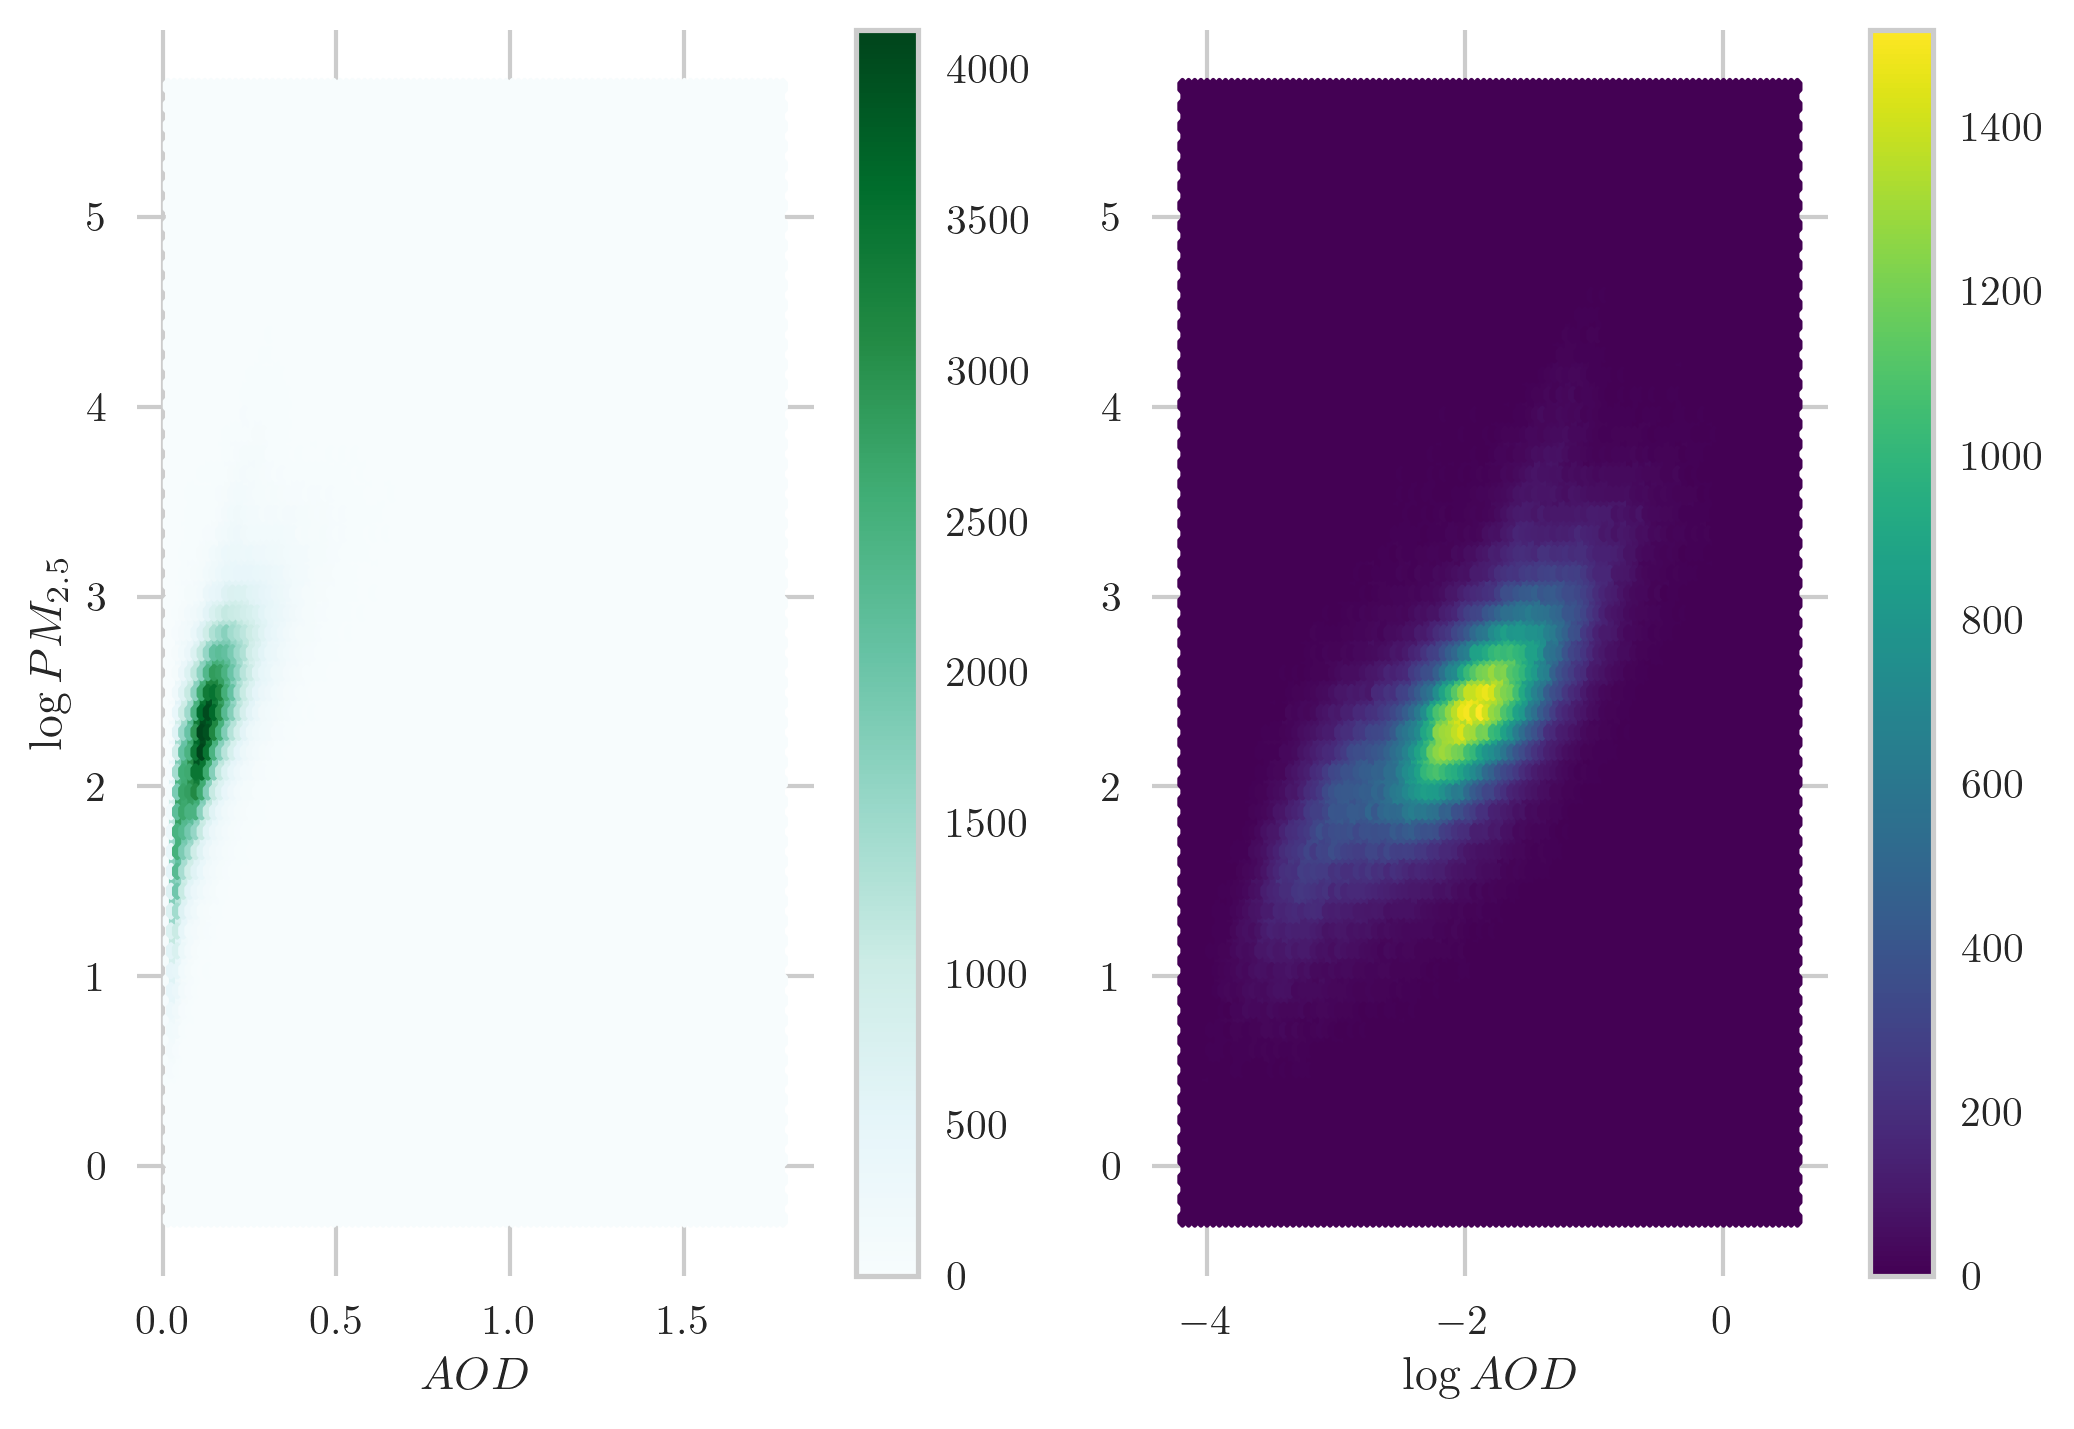

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

aod_only = pd.concat([x_train['AODANA'], y_train], axis=1)
aod_only['logAOD'] = aod_only['AODANA'].map(np.log)

aod_only.plot.hexbin(x='AODANA', y='PM2.5', ax=ax1)
aod_only.plot.hexbin(x='logAOD', y='PM2.5', ax=ax2, cmap='viridis')

ax1.set_ylabel('$\log PM_{2.5}$')
ax2.set_ylabel('')

ax1.set_xlabel('$AOD$')
ax2.set_xlabel('$\log AOD$')

ax.grid(False)

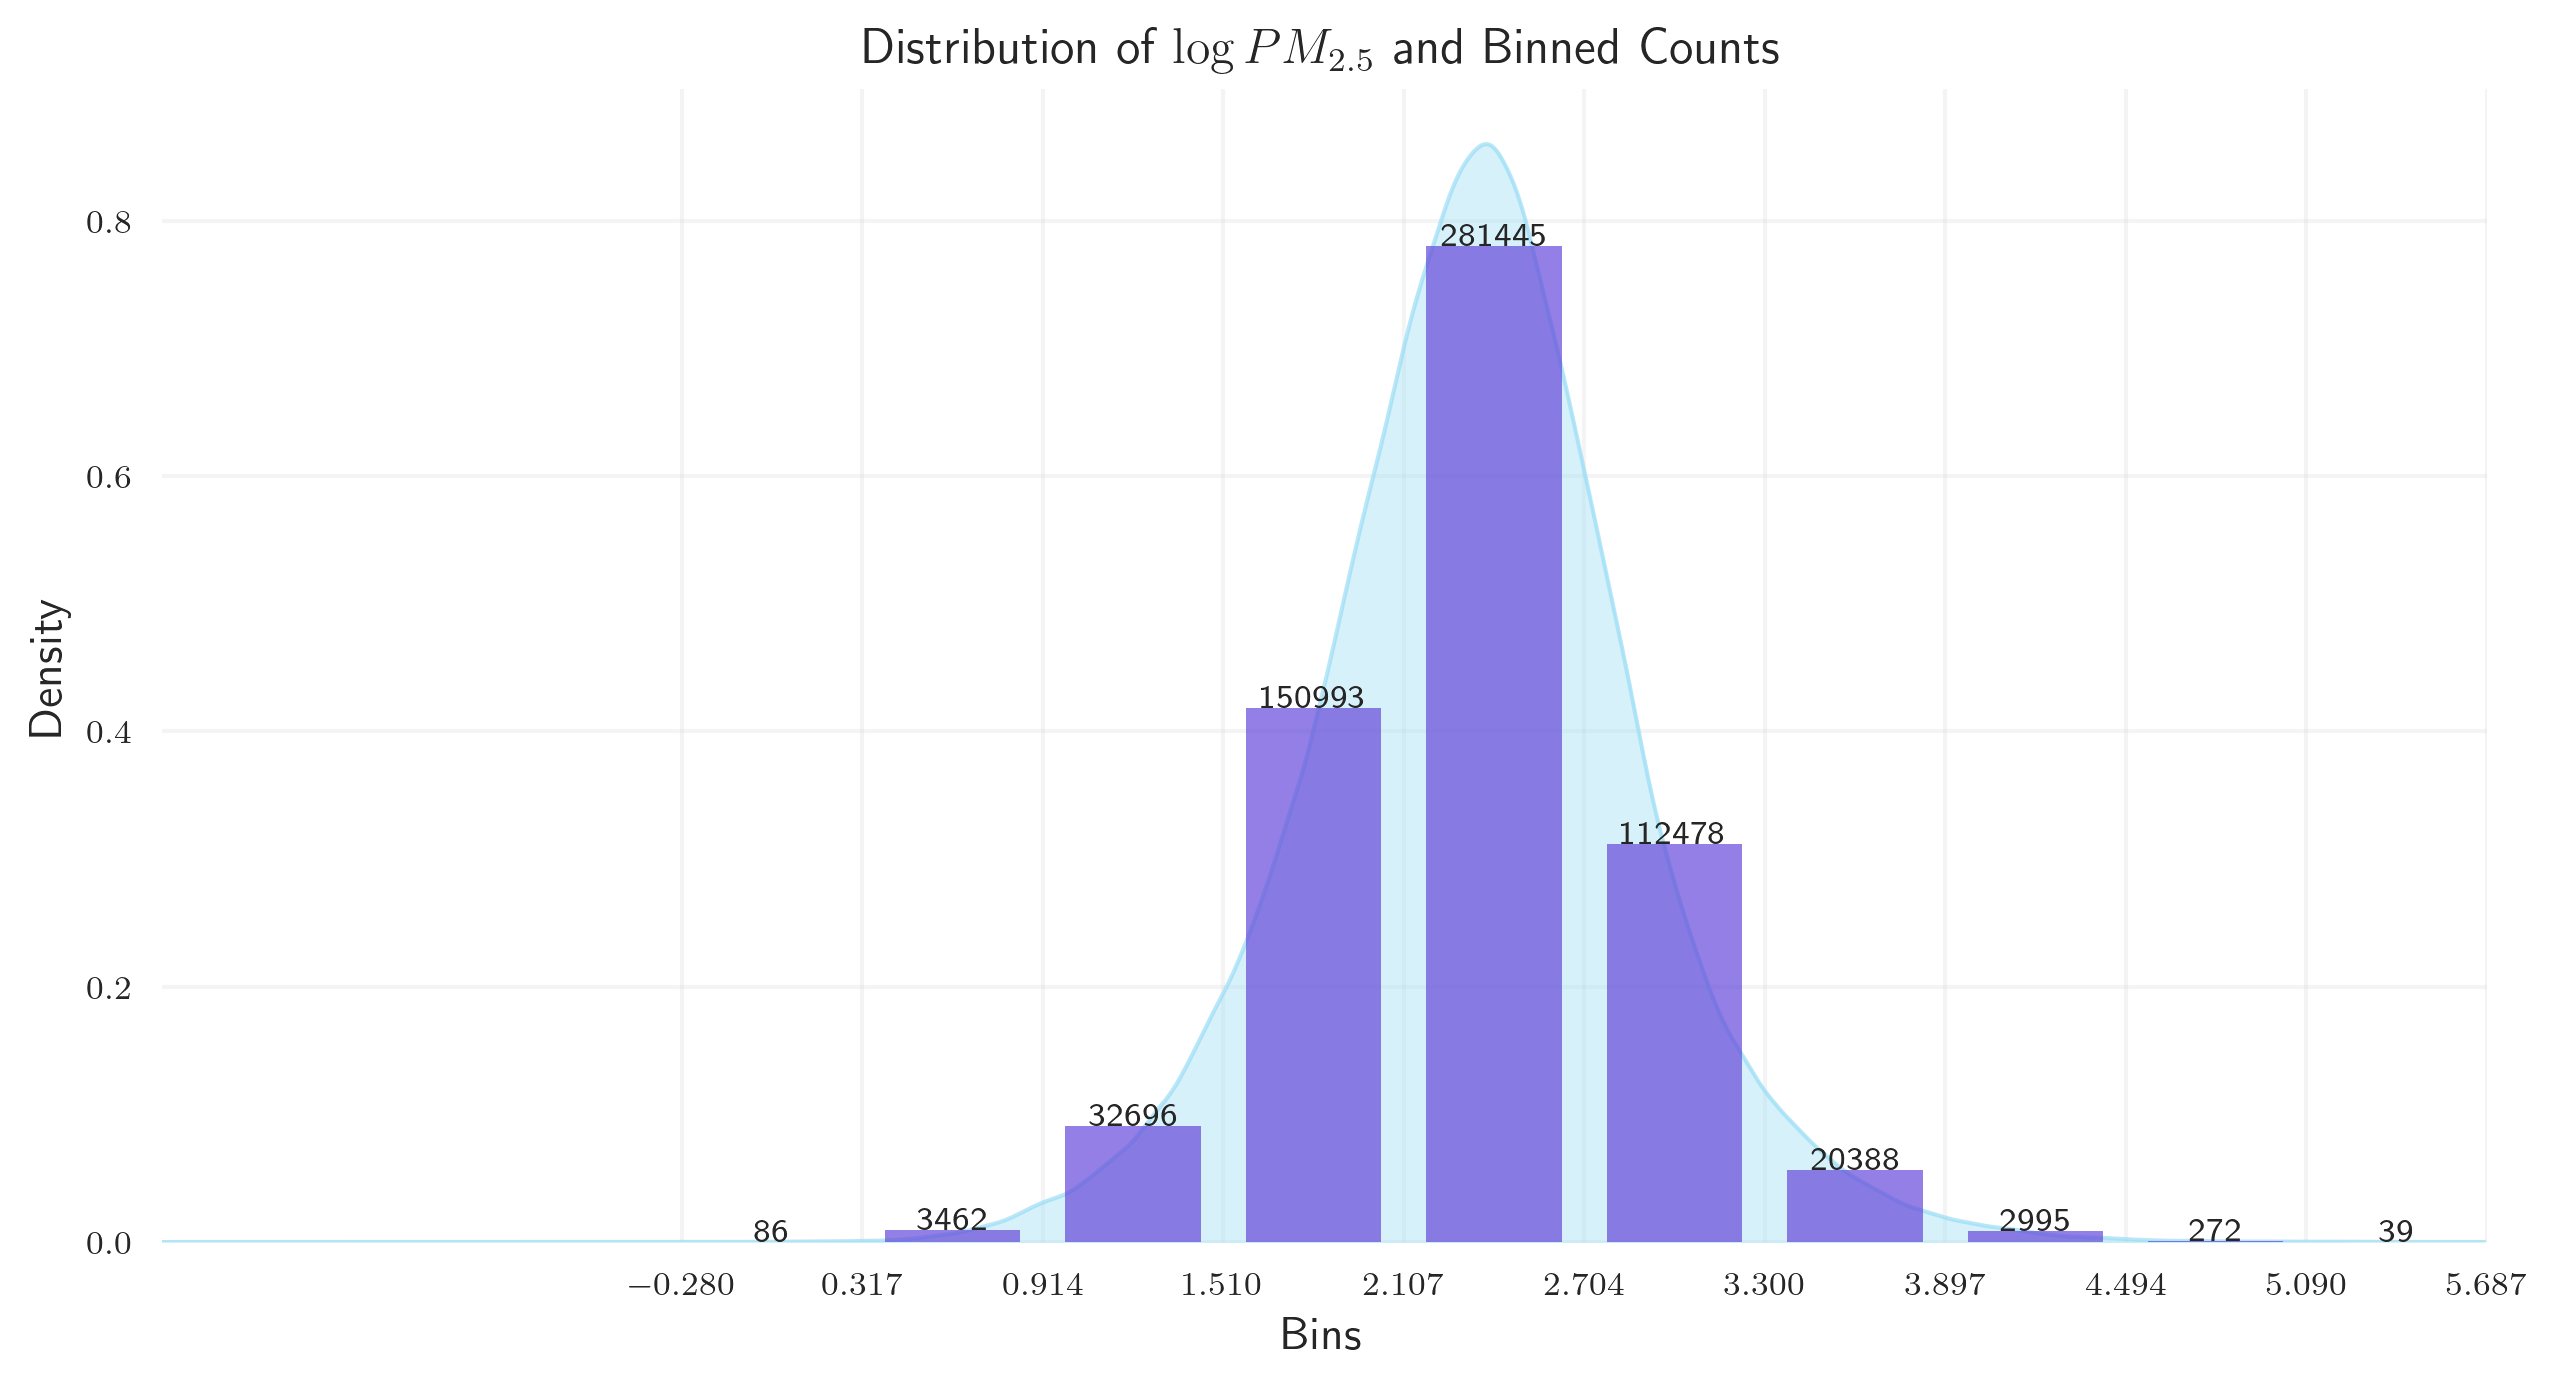

In [146]:
fig, ax = plt.subplots(dpi = 300, figsize=(10, 5.09))

bins = histogram_density_plot(train, 
                       by='PM2.5', 
                       nbins=10, 
                       title="Distribution of $\log PM_{2.5}$ and Binned Counts", 
                       tick_fontsize=8,
                       dpi=600,
                       xlabel='Bins',
                       ylabel='Density',
                       xmin=-2, 
                       ax=ax)

plt.savefig('figures/distribution.png')

In [32]:
predictions = pd.DataFrame(
    {
        name: model.predict(x_val.copy()) 
         for name, model in mc.models.items()
    }, index=x_val.index)

In [36]:
predictions = pd.concat([predictions, pd.DataFrame({'True Value': y_val}, index=x_val.index)], axis=1)

In [37]:
predictions

Linear Regression  Elastic Net  Polynomial  Bayesian Ridge  SVR  \
time                                                                          
2018-01-01               2.77         2.76        3.15            2.77 2.83   
2018-01-02               2.32         2.32        2.77            2.32 2.35   
2018-01-03               2.19         2.16        2.45            2.19 2.22   
2018-01-04               1.91         1.97        2.22            1.91 1.92   
2018-01-05               2.18         2.24        2.39            2.18 2.19   
...                       ...          ...         ...             ...  ...   
2019-06-26               2.41         2.39        2.48            2.41 2.38   
2019-06-27               2.39         2.38        2.35            2.39 2.36   
2019-06-28               2.37         2.34        2.25            2.37 2.33   
2019-06-29               2.39         2.36        2.41            2.39 2.36   
2019-06-30               2.35         2.32        2.24            2.35 2.32   

            Linear Mixed Effect  MLP  MLP1  MLP2  MLP3  Ada Boost  \
time                                                                
2018-01-01                 2.91 2.89  2.85  3.07  2.95       2.84   
2018-01-02                 2.40 2.34  2.31  2.40  2.46       2.44   
2018-01-03                 2.26 2.16  2.21  2.05  2.22       2.43   
2018-01-04                 2.00 2.06  1.87  1.84  1.89       1.96   
2018-01-05                 2.24 2.19  2.13  2.14  2.25       2.43   
...                         ...  ...   ...   ...   ...        ...   
2019-06-26                 2.43 2.49  2.38  2.40  2.63       2.39   
2019-06-27                 2.36 2.37  2.25  2.24  2.30       2.39   
2019-06-28                 2.31 2.29  2.15  2.16  2.18       2.30   
2019-06-29                 2.36 2.37  2.42  2.29  2.35       2.17   
2019-06-30                 2.30 2.10  2.18  2.09  2.09       2.15   

            Random Forest  Extra Trees  Gradient Boost  XGBoost  True Value  
time                                                                         
2018-01-01           2.95         3.02            2.86     2.86        2.91  
2018-01-02           2.64         2.38            2.47     2.51        2.45  
2018-01-03           2.16         2.11            2.32     2.34        2.48  
2018-01-04           1.95         2.08            2.08     2.09        2.16  
2018-01-05           2.28         2.47            2.29     2.31        1.84  
...                   ...          ...             ...      ...         ...  
2019-06-26           2.32         2.23            2.35     2.36        2.47  
2019-06-27           2.37         2.28            2.36     2.39        2.46  
2019-06-28           2.29         2.22            2.30     2.30        2.47  
2019-06-29           2.22         2.23            2.25     2.31        2.66  
2019-06-30           2.15         2.23            2.19     2.26        2.24  

[113022 rows x 16 columns]

In [38]:
import joypy

Text(0.5, 28.5, '$\\ln[PM_{2.5}] ~ \\mu g/m^3$')

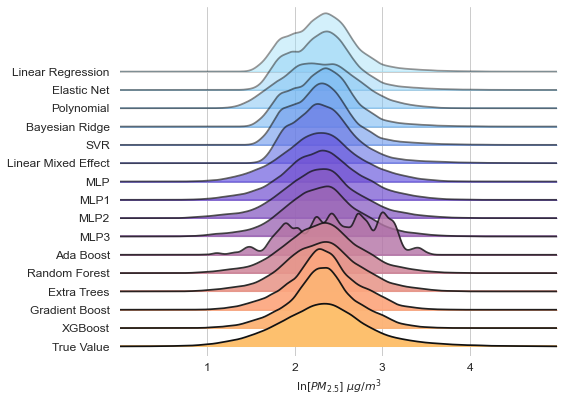

In [41]:
fig, axes = joypy.joyplot(predictions, fade=True, colormap=announce, x_range=(0, 5), grid=True)

axes[-1].set_xlabel('$\ln[PM_{2.5}] ~ \mu g/m^3$')

In [42]:
fig.savefig('figures/densities.svg', format='svg')

In [44]:
average_fit_times = {model: res['fit_time'].mean() for model, res in mc.cross_val_scores_.items()}
fit_times_error = {model: np.std(res['fit_time'], ddof=1) / np.sqrt(np.size(res['fit_time'])) for model, res in mc.cross_val_scores_.items()}

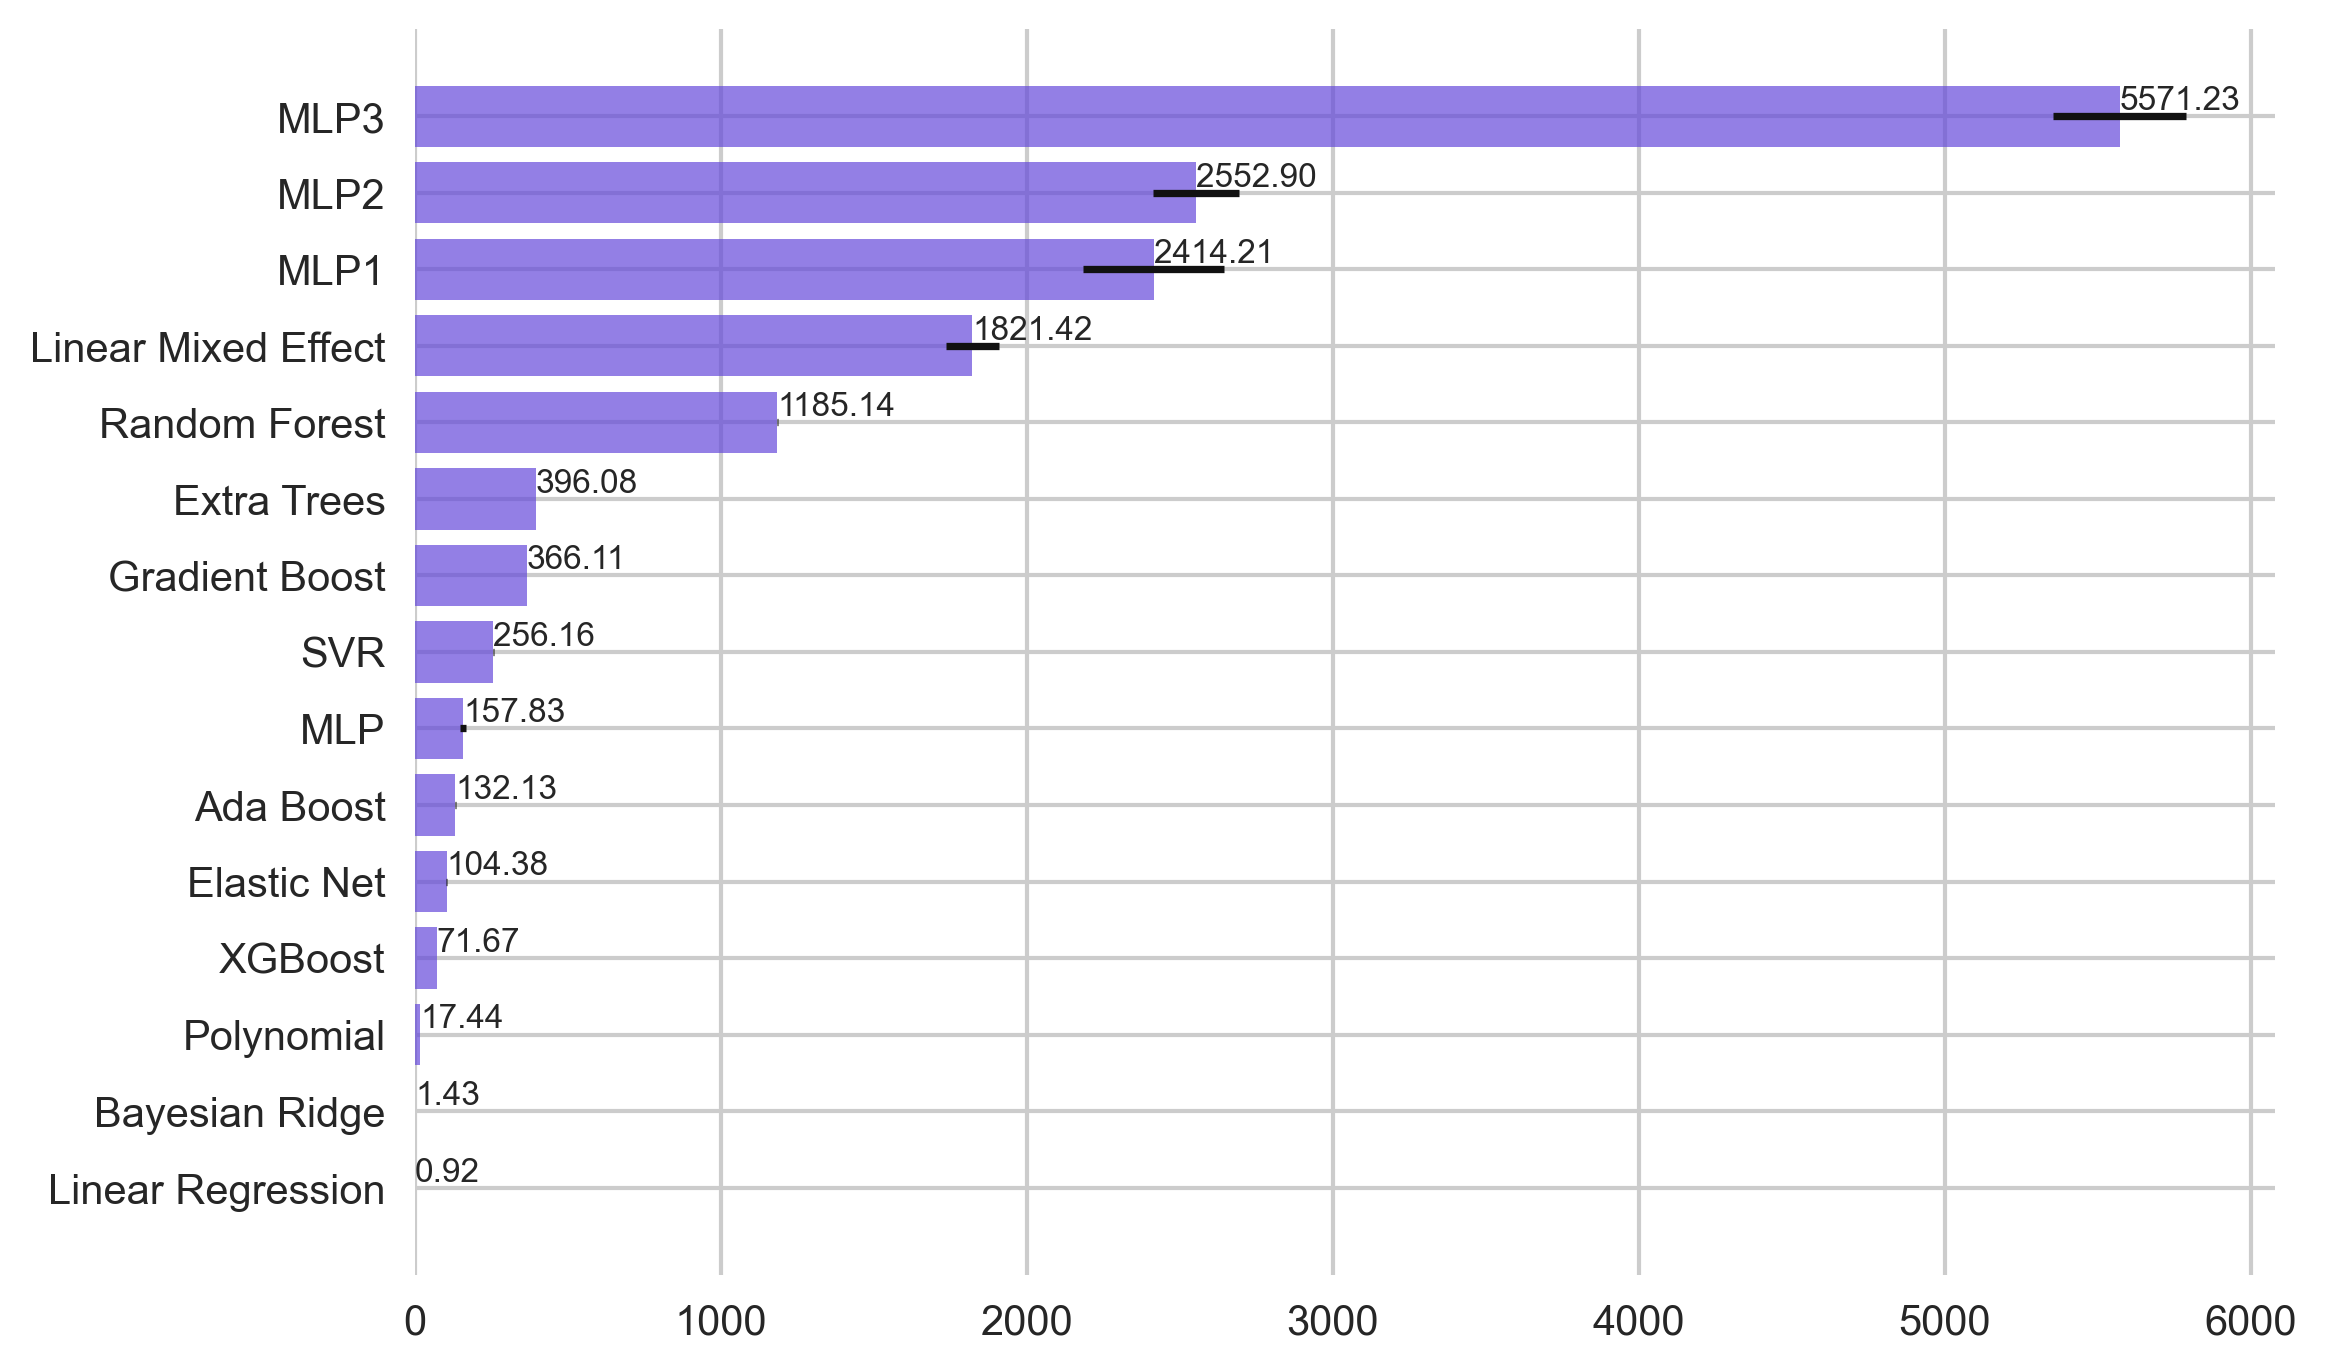

In [45]:
fig, ax = plt.subplots(dpi=300)

labels, values = map(np.array, zip(*average_fit_times.items()))
sort = np.argsort(values)

labels, values = labels[sort], values[sort]
xerr = np.array(list(fit_times_error.values()))[sort]

patches = ax.barh(labels, 
                  values, 
                  xerr=xerr,
                  alpha=0.7,
                  color='#6549DA')

for idx, patch in enumerate(patches):
    which = labels[idx]
    bl = patch.get_xy()
    x = patch.get_width() + bl[0] + .01
    y = 0.5*patch.get_height() + bl[1]
    ax.text(x, y, 
            f'{average_fit_times[which]:0.2f}', 
            fontsize=8, 
            ha='left',
            va='bottom')
    
fig.savefig('figures/fit_times.svg', format='svg', bbox_inches='tight')

In [46]:
results = pd.concat([predictions, val[['lat', 'lon']]], axis=1)
results = results.reset_index().set_index(['lat', 'lon', 'time']).to_xarray()
results = results.apply(np.exp)
results.to_netcdf('validation_results.nc4')

In [28]:
with xr.open_dataset('validation_results.nc4') as results:
    results.load()
    
results

<xarray.Dataset>
Dimensions:              (lat: 22, lon: 21, time: 546)
Coordinates:
  * lat                  (lat) float64 26.0 26.5 27.0 27.5 ... 35.5 36.0 36.5
  * lon                  (lon) float64 -106.2 -105.6 -105.0 ... -94.38 -93.75
  * time                 (time) datetime64[ns] 2018-01-01 ... 2019-06-30
Data variables: (12/16)
    Linear Regression    (lat, lon, time) float64 nan nan nan ... nan nan nan
    Elastic Net          (lat, lon, time) float64 nan nan nan ... nan nan nan
    Polynomial           (lat, lon, time) float64 nan nan nan ... nan nan nan
    Bayesian Ridge       (lat, lon, time) float64 nan nan nan ... nan nan nan
    SVR                  (lat, lon, time) float64 nan nan nan ... nan nan nan
    Linear Mixed Effect  (lat, lon, time) float64 nan nan nan ... nan nan nan
    ...                   ...
    Ada Boost            (lat, lon, time) float64 nan nan nan ... nan nan nan
    Random Forest        (lat, lon, time) float64 nan nan nan ... nan nan nan
    Extra Trees          (lat, lon, time) float64 nan nan nan ... nan nan nan
    Gradient Boost       (lat, lon, time) float64 nan nan nan ... nan nan nan
    XGBoost              (lat, lon, time) float32 nan nan nan ... nan nan nan
    True Value           (lat, lon, time) float32 nan nan nan ... nan nan nan

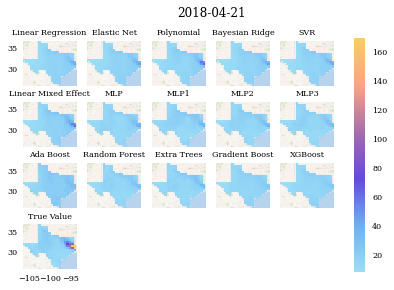

In [34]:
true = results['True Value']
max_pm_occurence = true.where(true==true.max(), drop=True).squeeze().time.values
ds = results.sel(time=max_pm_occurence)

fig_title = np.datetime_as_string(max_pm_occurence, unit='D')

fig, axes = map_predicted(ds, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/max_pm_with_predictions.svg', format='svg', bbox_inches='tight')

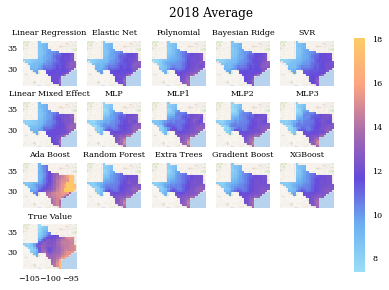

In [35]:
avg_2018 = results.resample(time="Y").mean().sel(time='2018')

fig_title = '2018 Average'

fig, axes = map_predicted(avg_2018, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/2018_average_predictions.svg', format='svg', bbox_inches='tight')

In [36]:
difference_from_true_2018 = avg_2018.to_dataframe().reset_index('time').dropna().drop(['time'], axis=1)
true_series = difference_from_true_2018['True Value']
difference_from_true_2018.drop(['True Value'], axis=1, inplace=True)
cols = difference_from_true_2018.columns
difference_from_true_2018[cols] = difference_from_true_2018[cols].sub(true_series.squeeze(), axis=0)
difference_from_true_2018 = difference_from_true_2018.to_xarray()

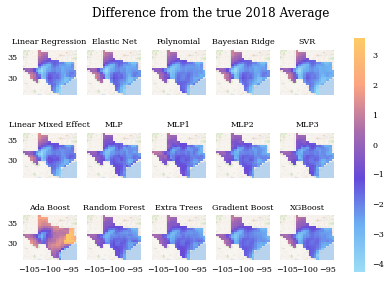

In [37]:
fig_title = 'Difference from the true 2018 Average'

fig, axes = map_predicted(difference_from_true_2018, nrows=3, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/2018_difference_from_true_mean.svg', format='svg', bbox_inches='tight')

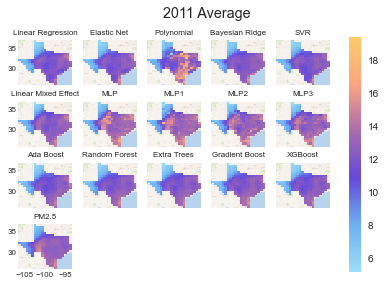

In [65]:
ds = yearly_avgs.apply(np.exp).to_xarray()

fig_title = '2011 Average'

fig, axes = map_predicted(ds, nrows=4, ncols=5, colormap=announce)

fig.suptitle(fig_title);
fig.savefig('figures/2011_grid-by-grid_averages_log_aod.svg', format='svg', bbox_inches='tight')

# Separating data by region

In [78]:
import geopandas as gpd
import rioxarray

In [79]:
gdf = gpd.read_file('/Users/kyle/Downloads/tx_eco_l4/tx_eco_l4.shp')

In [80]:
gdf = gdf.to_crs('EPSG:4326')

In [81]:
coast = gdf.where(gdf['US_L3NAME'] == 'Western Gulf Coastal Plain')

<AxesSubplot:>

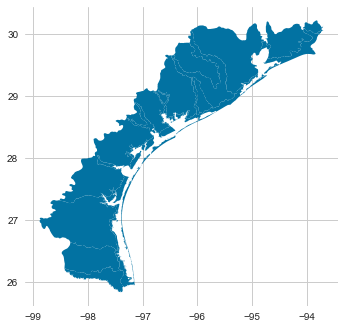

In [92]:
coast.plot()

In [82]:
xr_train = train.reset_index().set_index(['time', 'lat', 'lon']).to_xarray()

In [85]:
xr_train.rio.set_spatial_dims('lon', 'lat', inplace=True)
xr_train.rio.write_crs('EPSG:4326', inplace=True)

clipped = xr_train.rio.clip(
    [coast.__geo_interface__['features'][0]['geometry']], 
    crs='EPSG:4326', all_touched=True
)

In [90]:
clipped.sel(time='2010-01-01')

<xarray.Dataset>
Dimensions:      (lat: 1, lon: 2)
Coordinates:
  * lat          (lat) float64 27.5
  * lon          (lon) float64 -97.5 -96.88
    time         datetime64[ns] 2010-01-01
    spatial_ref  int64 0
Data variables: (12/24)
    PS           (lat, lon) float32 1.027e+05 nan
    QV2M         (lat, lon) float32 0.00617 nan
    QV10M        (lat, lon) float32 0.005983 nan
    T2M          (lat, lon) float32 283.7 nan
    T10M         (lat, lon) float32 283.6 nan
    U2M          (lat, lon) float32 0.2883 nan
    ...           ...
    TS           (lat, lon) float32 285.4 nan
    MonthSin     (lat, lon) float64 0.5 nan
    MonthCos     (lat, lon) float64 0.866 nan
    TPRECMAX     (lat, lon) float32 3.002e-05 nan
    DISPH        (lat, lon) float32 0.1623 nan
    EMIS         (lat, lon) float32 0.9737 nan